# Body Fat - Explore

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import random as py_random
import numpy.random as np_random
import time
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from IPython.display import Image

sns.set(style="whitegrid")

Let's import our data set.

The file `bodyfat.db` contains data about body fat percentage as well as some basic measurements (density, age, weight, height, neck, chest, abdomen, hip, thigh, knee, ankle, biceps, forearm, wrist).

* [bodyfat](#bodyfat)
* [density](#density)
* [age](#age)
* [weight](#weight)
* [height](#height)
* [neck](#neck)
* [chest](#chest)
* [abdomen](#abdomen)
* [hip](#hip)
* [thigh](#thigh)
* [knee](#knee)
* [ankle](#ankle)
* [biceps](#biceps)
* [forearm](#forearm)
* [wrist](#wrist)

The question or problem is to determine if body fat has any relationship with the other values. This exploratory data analysis is just the first step. We will first look at the patterns in each individual variable and then look to see if there are any patterns between body fat and any of the other variables.

We start by loading the data. We made a file bodyfat_db.py that creates a datawarehouse containing our complete data set. We will work on these by connecting to the database created. 

In [4]:
from tabulate import tabulate
from bodyfat_get import main
import sqlite3

#remove existing database
!rm bodyfat.db
#stuff table into database
!sqlite3 bodyfat.db < bodyfat.sql
#build database and establish connection
main()
con = sqlite3.connect('bodyfat.db')

Let's test the connection by making sure we have 252 rows:

In [5]:
print("Number of observations:", list(con.execute("SELECT COUNT(*) FROM Body_Fat"))[0][0])

Number of observations: 252


Great. We are ready to begin our exploration of the data.

# EDA

## Single Variable EDA

We'll start our EDA by looking at each variable individually, starting with the target variable, *bodyfat*.

<a id="bodyfat"></a> 

## Body Fat

Body Fat is the main variable of interest and represent percentage of body fat of each person in database. As previously stated it is determined using the density after submerging the person into a water tank. [In 2015-2016, men in the United States averaged 28.7% measured by DXA.](https://dqydj.com/body-fat-percentage-distribution-men-women/) 

We expect this data set to be a random sample of American men. Since Americans are usually on the fatter side, we should expect a skewed distribution with more "fatter" men. 

We'll start by importing the variable and reviewing some summary statistics. 

In [6]:
query = """
SELECT BodyFat_brozek
FROM Body_Fat
"""
bodyfat = pd.DataFrame(con.execute(query), columns = ["BodyFat"])

In [7]:
bodyfat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BodyFat  252 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB


We have no missing values.

In [8]:
bodyfat.describe()

,BodyFat
count,252.000000
mean,18.878175
std,7.818945
min,-2.100000
25%,12.700000
50%,19.000000
75%,24.600000
max,45.100000


The variable is slightly skewed. While the mean [18.8] and the median [19] are more or less the same, the standardized IQR are [2.6, 1.1, 1, 3.6]. As expected the 4th quartile is about 1.5 times the range of the 1st quartile. As such, we should expect a skew with long tails on the right.

In addition, while the maximum looks like a plausible (but not so healthy) value, the minimum value of -2.1 is mathematically impossible. In fact, we shouldn't expect any living person to [have 0% body fat](https://abcnews.go.com/Health/legendary-bodybuilder-died-body-fat-lives/story?id=29899438). We should therefore be sure to examine this point in detail.

Let's plot a histogram of the data using Freeman Diaconis bins:

In [9]:
def freeman_diaconis( data):
    quartiles = stats.mstats.mquantiles( data, [0.25, 0.5, 0.75])
    iqr = quartiles[2] - quartiles[ 0]
    n = len( data)
    h = 2.0 * (iqr/n**(1.0/3.0))
    return int( h)

Freeman Diaconis:  3


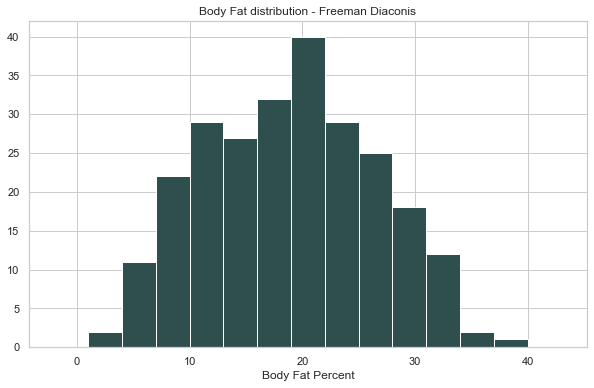

In [10]:
h = freeman_diaconis(bodyfat)
print("Freeman Diaconis: ", h)
mn = int(bodyfat.min())
mx = int(bodyfat.max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(bodyfat,bins=bins, color="darkslategray")
axes.set_title("Body Fat distribution - Freeman Diaconis")
axes.set_xlabel("Body Fat Percent")

plt.show()
plt.close()

The data has a very symmetric distribution. It's hard to see if there is a skew. Let's see if a better binning can clean up the resolution of the histogram.

There aren't so many values that we couldn't just use a bin size of 1. Let's first look at the rawest resolution of the data:

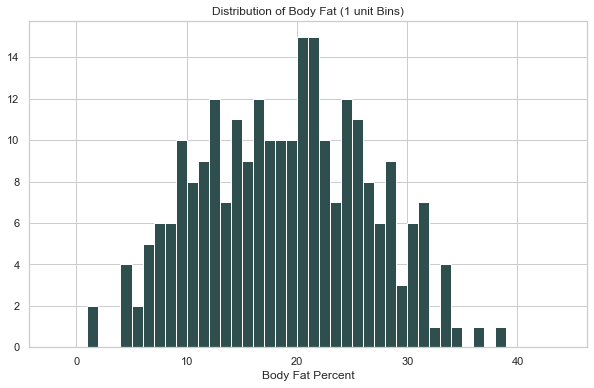

In [11]:
mn = int(bodyfat.min())
mx = int(bodyfat.max())
bmi_bins = [i for i in range(mn, mx, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(bodyfat,bins=bmi_bins, color="darkslategray")
axes.set_title("Distribution of Body Fat (1 unit Bins)")
axes.set_xlabel("Body Fat Percent")

plt.show()
plt.close()

It's still too hard to see a skew. This is perhaps too granular, so let's take a look at it with default bins:

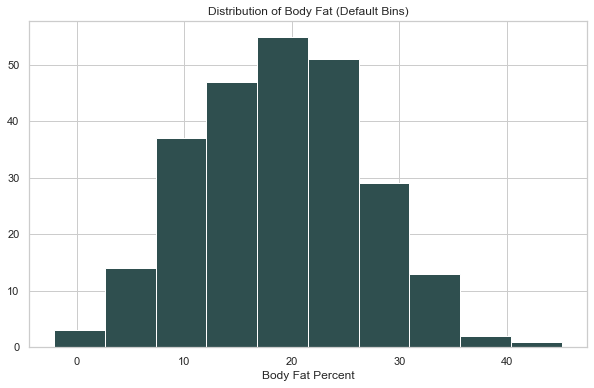

In [12]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(bodyfat, color="darkslategray")
axes.set_title("Distribution of Body Fat (Default Bins)")
axes.set_xlabel("Body Fat Percent")

plt.show()
plt.close()

The distribution of body fat is more or less approximating normal with a slight right skew and long tails on the right. We may have to apply a transformation. 


Of concern was that data point that equaled zero. The [article](https://abcnews.go.com/Health/legendary-bodybuilder-died-body-fat-lives/story?id=29899438) above previously stated that a body fat equal to 1% or less is lethal, so let's see how many points are less than 1% body fat. 

In [13]:
bodyfat[bodyfat.BodyFat <= 1]

,BodyFat
181,-2.1


It looks like we have just one problematic point. Body fat percent cannot be less than 0%, so we should examine this point in more detail to determine whether it is an entry error or if Brozek's equation simply can't approximate his person's body fat due to some extreme measurement.

In [14]:
query = """
SELECT Density, BodyFat_brozek, Weight, Height, Age
FROM Body_Fat
WHERE BodyFat_brozek <= 1
"""
result = list(con.execute(query))
tabulate(result, headers = ["Density", "Body Fat", "Weight", "Height", "Age"],  tablefmt='html')

Density,Body Fat,Weight,Height,Age
1.1089,-2.1,118.5,68,40


This individual has a comparatively "high" density of 1.1089 and should have very low body fat scores. This person is of average height but his weight is remarkably low. 

So it seems that Brozek's equation doesn't approximate very well when people have very high denisties. Guerra et al tells us that Brozek's equation might over or under estimate body fat with a mean of 5.7% [for a person in at this age and sex](https://www.researchgate.net/profile/Jorge-Mota-8/publication/47813165_Accuracy_of_Siri_and_Brozek_equations_in_the_percent_body_fat_estimation_in_older_adults/links/0046351557ebd6fe68000000/Accuracy-of-Siri-and-Brozek-equations-in-the-percent-body-fat-estimation-in-older-adults.pdf). Therefore we will impute this score to 0 which is improbable but at least mathematically makes sense. 

In [15]:
bodyfat.iloc[181,0] = 0.0
bodyfat.iloc[181,0]

0.0

Lastly, we can divide our sample by criteria set by the ACE.

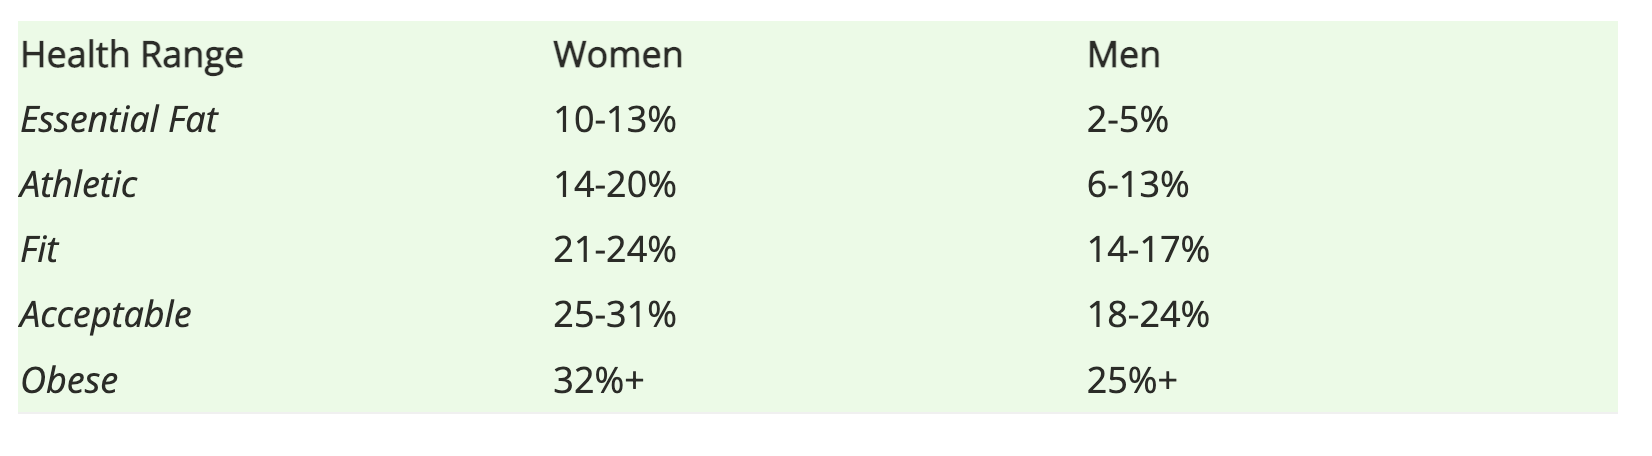

In [16]:
Image("ranges.png")

Let's see what proportion of our sample falls into each of these categories:

In [17]:
ACE_pd = pd.DataFrame(bodyfat)

#create our list of conditions for the 5 body fat groups
conditions = [
    (ACE_pd["BodyFat"] <= 5),
    (ACE_pd["BodyFat"] > 5) & (ACE_pd["BodyFat"] <=13),
    (ACE_pd["BodyFat"] > 13) & (ACE_pd["BodyFat"] <=17),
    (ACE_pd["BodyFat"] > 17) & (ACE_pd["BodyFat"] <=24),
    (ACE_pd["BodyFat"] > 24)]

#create a list of the values we want to assign for each condition
values = ["Essential Fat", "Athletic", "Fit", "Acceptable", "Obese"]

#add a new column with values
ACE_pd["BF_Group"] = np.select(conditions, values)

In [18]:
ACE_pd.BF_Group.value_counts()/len(bodyfat)

Acceptable       0.309524
Obese            0.273810
Athletic         0.226190
Fit              0.158730
Essential Fat    0.031746
Name: BF_Group, dtype: float64

We can see 31% of the data are acceptable, 27% are obese, 23% are atheletic, 16% are fit and 3% are have just an essential amount of fat. 

<a id="density"></a>

## Density

Density is a numeric variable, measured in gm/$cm^3$. The value is determined by conducting an underwater weighing of the subject, and comparing the weight to the subject's air weight. Since water has density equal to 1, and fat much less, the combination of these two combine to give a composite density. The larger the density, the lower the body fat percentage, and vice versa. 

As this value directly computes the body fat, we should expect this to have a similar distribution as body fat. 

Let's first look at the summary statistics for Density to get a sense for the range actually covered and if there are any anomalies.

In [19]:
query = """
SELECT Density
FROM Body_Fat
"""
density = pd.DataFrame(con.execute(query), columns = ["Density"])

In [20]:
density.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Density  252 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB


Looks like we have no null values.

In [21]:
density.describe()

,Density
count,252.000000
mean,1.055574
std,0.019031
min,0.995000
25%,1.041400
50%,1.054900
75%,1.070400
max,1.108900


The variable is slightly skewed. While the mean [1.055574] and the median [1.054900] are more or less the same, and the quartiles follows the opposite differential as Body Fat. In other words, the standardized IQR is [3.4, 1, 1.1 2.9], which is the reverse of the body fat IQR.

Let's examine the resulting histogram. Since Body Fat is determiend by a formula using the Density, and the two are inversely proportional, we should expect its histogram to be the reverse of the distribution of Body Fat. 

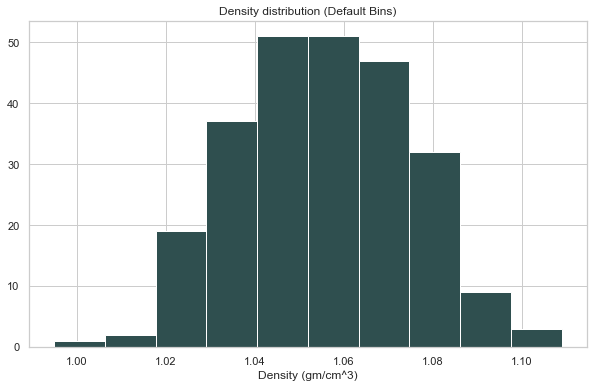

In [22]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(density, color="darkslategray")
axes.set_title("Density distribution (Default Bins)")
axes.set_xlabel("Density (gm/cm^3)")

plt.show()
plt.close() 

We can see that the distribution approximates a normal distribution with a slight left skew. It matches very closely the distribution of the Body Fat but oppositely. 

<a id="age"></a>
## Age

Age is a numeric variable. Since this sample set is rather small and probably conducted in a university setting, we expect that the data will be distributed around a narrow age range than the population. 

Let's first look at the summary statistics for Age to get a sense for the range actually covered and if there are any anomalies (0 or negative ages, 300 year olds).

In [23]:
query = """
SELECT Age
FROM Body_Fat
"""
age = pd.DataFrame(con.execute(query), columns = ["Age"])

In [24]:
age.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Age     252 non-null    int64
dtypes: int64(1)
memory usage: 2.1 KB


We have no missing values.

In [25]:
age.describe()

,Age
count,252.000000
mean,44.884921
std,12.602040
min,22.000000
25%,35.750000
50%,43.000000
75%,54.000000
max,81.000000


The minimum age is 22, and the maximum age is 81. The mean [44.8] and the media [43] do not match and the scaled IQR [1.9,1,1.5, 3.8], shows us that older ages may be overrepresented. Age is numerical so we can do a histogram.

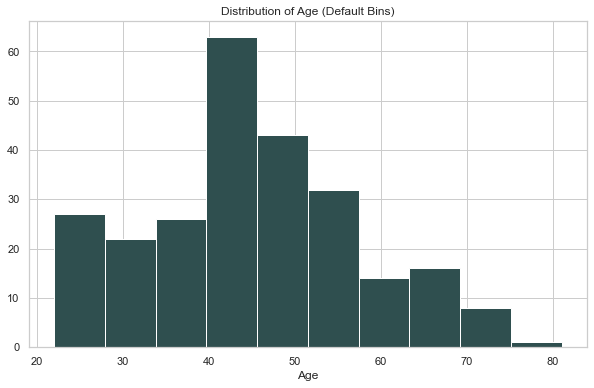

In [26]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(age, color="darkslategray")
axes.set_title("Distribution of Age (Default Bins)")
axes.set_xlabel("Age")

plt.show()
plt.close()

There are two things that jump out. First, there are a lot of records for people around 40 years of age and, second, the distribution for the other ages is relatively uniform until age 60 where it drops off. If we compare it to the male side of population period from 2000, it isn't too far off. 

![Population Pyramid](http://www.censusscope.org/us/chart_age_graph_1.gif)

Our sample, however seems to be underrepresenting those above 50. We can therefore only conjecture that this approximates a random sample of men aged 22 and up. 

Lastly, let's check the distribution of ages if we were use age groups for every decade. Since there is only one person above 80 will include him in the 70 and up group.

In [27]:
age_pd = pd.DataFrame(age)

#create our list of conditions for the 9 age groups
conditions = [
    (age_pd["Age"] <= 30),
    (age_pd["Age"] > 30) & (age_pd["Age"] <=40),
    (age_pd["Age"] > 40) & (age_pd["Age"] <=50),
    (age_pd["Age"] > 50) & (age_pd["Age"] <=60),
    (age_pd["Age"] > 60) & (age_pd["Age"] <= 70),
    (age_pd["Age"] > 70)]

#create a list of the values we want to assign for each condition
values = [20, 30, 40, 50, 60, 70]

#add a new column with values
age_pd["Age_Group"] = np.select(conditions, values)

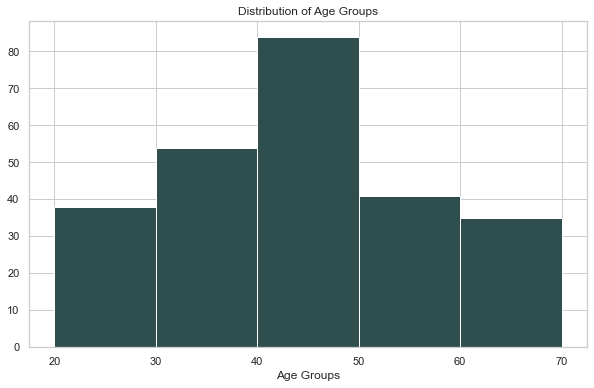

In [28]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(age_pd["Age_Group"], bins = 5, color="darkslategray")
axes.set_title("Distribution of Age Groups")
axes.set_xlabel("Age Groups")

plt.show()
plt.close()

When the ages are "binned" by decade, they look like more normally distributed, but only slightly. We still have right skew.

<a id="weight"></a>
## Weight

Weight is a numeric variable, measured in lbs. As Americans are usually fat, we should expect a right skew. The men here are also 22 and up so we should expect to see adult weights only, ie nothing less than 100 lbs.

In [29]:
query = """
SELECT Weight
FROM Body_Fat
"""
weight = pd.DataFrame(con.execute(query), columns = ["Weight"])

In [30]:
weight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Weight  252 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB


We have no missing values. 

In [31]:
weight.describe()

,Weight
count,252.000000
mean,178.924405
std,29.389160
min,118.500000
25%,159.000000
50%,176.500000
75%,197.000000
max,363.150000


The mean weight [178.92] and median weight [176.5] are about the same, and the 3rd quartile does look larger than the 2nd. The min and max are definitely possible values, so we have no concerns about impossible weights.

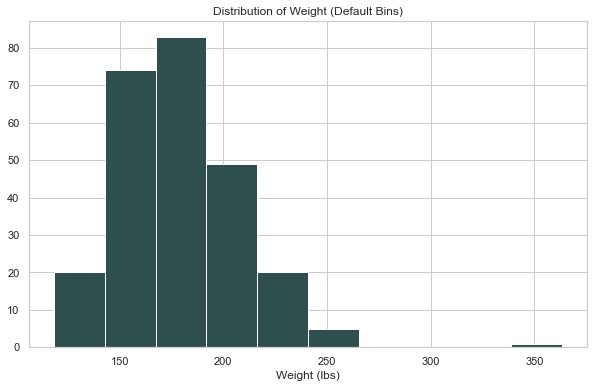

In [32]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(weight, color="darkslategray")
axes.set_title("Distribution of Weight (Default Bins)")
axes.set_xlabel("Weight (lbs)")

plt.show()
plt.close()

The distribution looks like its approximating normal with a right skew and a solitary outlier far away from the rest. We shouldn't be surprised that this distribution doesn't match body fat distribution, as weight and body fat are not interchangeable. Someone can be a body builder, weigh a lot, but have a low body fat. 

<a id="height"></a>
## Height

Height is a numeric variable, measured in inches, unlike the other measurements which are in centimeters. 

Since age was distributed approximately to the same as the US population, we should expect height to have a distribution approximating the adult male population of the US. 

In [33]:
query = """
SELECT Height
FROM Body_Fat
"""
height = pd.DataFrame(con.execute(query), columns = ["Height"])

In [34]:
height.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Height  252 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB


We have no null values.

In [35]:
height.describe()

,Height
count,252.000000
mean,70.148810
std,3.662856
min,29.500000
25%,68.250000
50%,70.000000
75%,72.250000
max,77.750000


The height looks as expected with the mean [70.1] and median [70] matching. The scaled IQR [22.1, 1, 1.3, 3.1]. We have evidence of a severe left skew. 

We do have at least one person who is 29.5 inches tall. This may be an error as well. So we will have to check it. 

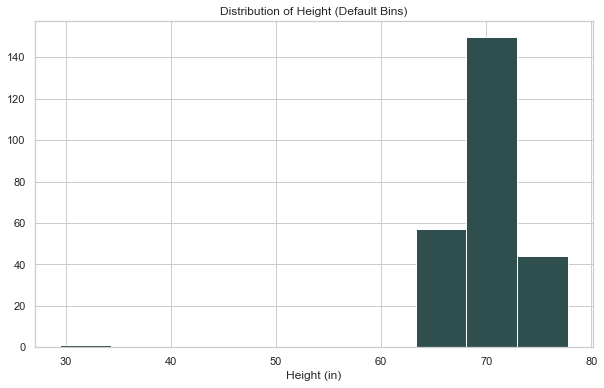

In [36]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(height, color="darkslategray")
axes.set_title("Distribution of Height (Default Bins)")
axes.set_xlabel("Height (in)")

plt.show()
plt.close() 

I think we can go a bit more granular. 

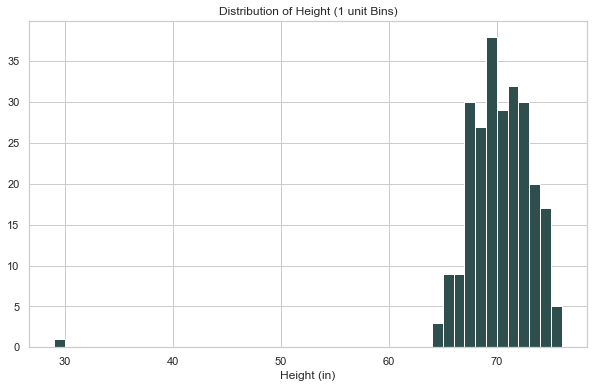

In [37]:
mn = int(height.min())
mx = int(height.max())
bmi_bins = [i for i in np.arange(mn, mx, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(height,bins=bmi_bins, color="darkslategray")
axes.set_title("Distribution of Height (1 unit Bins)")
axes.set_xlabel("Height (in)")

plt.show()
plt.close() 

The distribution looks like its approximating the distribution for height, except that sole outlier. Let's see if we can gather more information about this point.

In [38]:
query = """
SELECT *
FROM Body_Fat
WHERE Height < 60
"""
result = list(con.execute(query))
tabulate(result, headers = ["ID", "Body Fat_siri", "Body Fat_brozek","Density", "Age",
                            "Height", "Weight", "Neck", "Chest",
                            "Abdomen", "Hip", "Thigh", "Knee",
                            "Ankle", "Biceps", "Forearm", "Wrist"],  tablefmt='html')

ID,Body Fat_siri,Body Fat_brozek,Density,Age,Height,Weight,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
42,32.9,31.7,1.025,44,29.5,205,36.6,106,104.3,115.5,70.6,42.5,23.7,33.6,28.7,17.4


We need to convert all the measurements after neck to inches so we can compare this persons height to the other measurements. 

In [39]:
result2 = [[]]

for i in range(len(result[0])):
    if i < 7:
        result2[0].append(result[0][i])
    else:
        result2[0].append(result[0][i]/2.54)

tabulate(result2, headers = ["ID", "Body Fat_siri", "Body Fat_brozek","Density", "Age",
                            "Height", "Weight", "Neck", "Chest",
                            "Abdomen", "Hip", "Thigh", "Knee",
                            "Ankle", "Biceps", "Forearm", "Wrist"],  tablefmt='html')  

ID,Body Fat_siri,Body Fat_brozek,Density,Age,Height,Weight,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
42,32.9,31.7,1.025,44,29.5,205,14.4094,41.7323,41.063,45.4724,27.7953,16.7323,9.33071,13.2283,11.2992,6.85039


Clearly there must have been a mistake here as this persons hip is 15 inches larger in circumference than his height. We should seriously consider removing this data point, or imputing it an estimate, as it's most likely a true error in recording. 

Let's check our distribution against the US distribution of male heights. 

![heights](https://www.myspreadsheetlab.com/wp-content/uploads/2019/10/Male-Height-in-United-States-average-and-standard-deviation.png)

Compared to the US male population, our sample has a larger standard deviation but the mean is about the same.

Earlier we stated that height is the only measurement that is in inches. We should therefore convert it to centimeters to match the rest of the measurements. 

In [40]:
height = height*2.54
height.describe()

,Height
count,252.000000
mean,178.177976
std,9.303654
min,74.930000
25%,173.355000
50%,177.800000
75%,183.515000
max,197.485000


<a id="neck"></a>
## Neck

Neck is a numeric variable, circumference of the neck measured in cm. Since we are just beginning to examine our circumference measurements, we really do not have any expectations for the distribution. 

In [41]:
query = """
SELECT Neck
FROM Body_Fat
"""
neck = pd.DataFrame(con.execute(query), columns = ["Neck"])

In [42]:
neck.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Neck    252 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB


We have no null values.

In [43]:
neck.describe()

,Neck
count,252.000000
mean,37.992063
std,2.430913
min,31.100000
25%,36.400000
50%,38.000000
75%,39.425000
max,51.200000


The mean [37.99] and median [38] are about the same. The scaled IQR range [3.7, 1.1, 1, 8.3] suggests we have a long tail on the right. We have no other values of concern here.

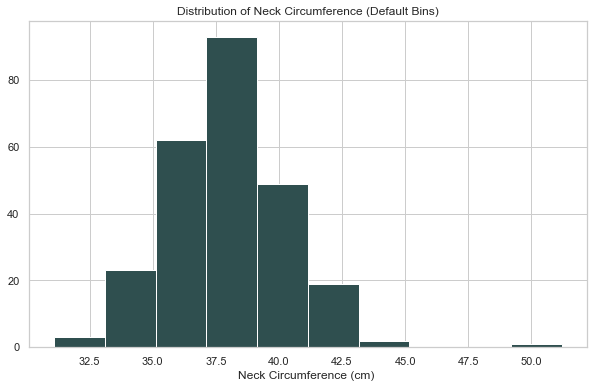

In [44]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(neck, color="darkslategray")
axes.set_title("Distribution of Neck Circumference (Default Bins)")
axes.set_xlabel("Neck Circumference (cm) ")

plt.show()
plt.close()

The distribution approximates a normal one. Our suggestion of a skew is unfounded. We do have one outlier out to the right which explains the large IQR. Otherwise, the distribution is rather symmetric and centered around the median.

Let's examine this outlier.

In [45]:
query = """
SELECT *
FROM Body_Fat
WHERE Neck > 47.5
"""
result = list(con.execute(query))
tabulate(result, headers = ["ID", "Body Fat", "Density", "Age",
                            "Height", "Weight", "Neck", "Chest",
                            "Abdomen", "Hip", "Thigh", "Knee",
                            "Ankle", "Biceps", "Forearm", "Wrist"],  tablefmt='html')

,ID,Body Fat,Density,Age,Height,Weight,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
39,35.2,33.8,1.0202,46,72.25,363.15,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45,29,21.4


This observation corresponds to the the one outlier we saw in the distributions of weight as well. It does not seem to exist outside the realm of possibility; however it is a little troubling that this person's neck is 1/3rd the size of his abdomen. 

<a id="Chest"></a>
## Chest

Chest is a numeric variable, circumference of the chest measured in cm. We should expect the chest measurement to follow a normal distribution perhaps skewed the to left, to account for the people who lift weights. I would imagine there are many people who work on making their chests larger and virtually none who want to make them smaller. 

In [46]:
query = """
SELECT Chest
FROM Body_Fat
"""
chest = pd.DataFrame(con.execute(query), columns = ["Chest"])

In [47]:
chest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Chest   252 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB


We have no null values. 

In [48]:
chest.describe()

,Chest
count,252.000000
mean,100.824206
std,8.430476
min,79.300000
25%,94.350000
50%,99.650000
75%,105.375000
max,136.200000


As before the mean (100.82) and median (99.65) are about the same. The standardized IQR [2.8, 1, 1.1, 5.8] indicates that the last quartile is almost twice as large as the first, hinting towards a long tails on the right. 

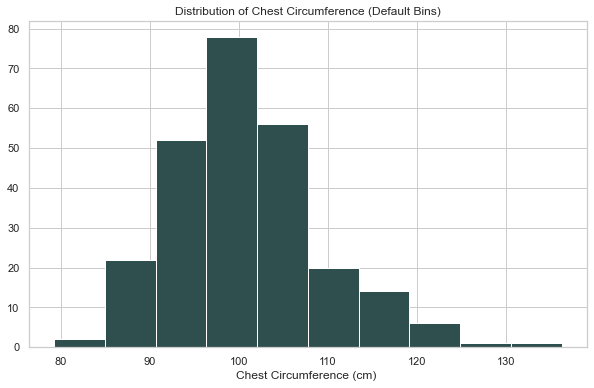

In [49]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(chest, color="darkslategray")
axes.set_title("Distribution of Chest Circumference (Default Bins)")
axes.set_xlabel("Chest Circumference (cm) ")

plt.show()
plt.close() 

While this distribution does approximate a normal one, we do have evidence of a right skew. We expected a few men who actively work on making their chests larger and this distribution seems to showcase them.

<a id="Abdomen"></a>
## Abdomen

Abdomen is a numeric variable, circumference of the abdomen measured in cm. We have no expectations on the distribution of abdomen, except that it should approximate a normal one. Perhaps this distribution should have an opposite orientation to chest since men are more likely to puff our their chests but suck in their gut. 

In [50]:
query = """
SELECT Abdomen
FROM Body_Fat
"""
abdomen = pd.DataFrame(con.execute(query), columns = ["Abdomen"])

In [51]:
abdomen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Abdomen  252 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB


We have no null values. 

In [52]:
abdomen.describe()

,Abdomen
count,252.000000
mean,92.555952
std,10.783077
min,69.400000
25%,84.575000
50%,90.950000
75%,99.325000
max,148.100000


The mean [92.6] is slightly ahead of median [91.0]. The standardized IQR [2.38, 1, 1.3, 7.6] indicates that the last quartile quartile is more than twice the first, hinting towards a long tails on the right. 

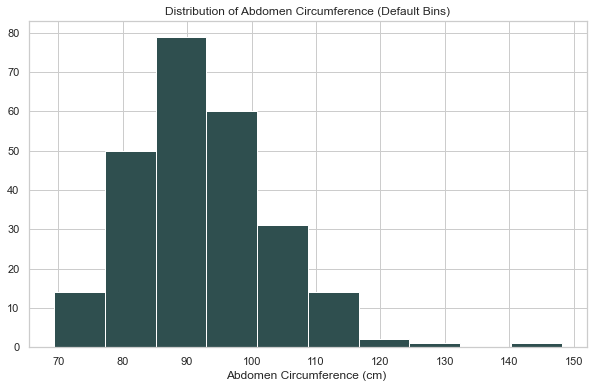

In [53]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(abdomen, color="darkslategray")
axes.set_title("Distribution of Abdomen Circumference (Default Bins)")
axes.set_xlabel("Abdomen Circumference (cm) ")

plt.show()
plt.close()

This more or less resembles the distribution of the chest size with a slight right skew and long tails on the right. 

<a id="Hip"></a>
## Hip

Hip is a numeric variable, circumference of the hip measured in cm. We should expect the hip measurement to follow a normal distribution resembling the previous circumferences, that is with a right skew. 

In [54]:
query = """
SELECT Hip
FROM Body_Fat
"""
hip = pd.DataFrame(con.execute(query), columns = ["Hip"])

In [55]:
hip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Hip     252 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB


We have no null values.

In [56]:
hip.describe()

,Hip
count,252.000000
mean,99.904762
std,7.164058
min,85.000000
25%,95.500000
50%,99.300000
75%,103.525000
max,147.700000


This distribution looks the most regular of all the ones we have seen so far. Its mean and median are about the same and the scaled IQR ranges [2.8, 1, 1.1, 11.625] indicate the last quartile is almost 4 times the first. We should expect a long tails on the right again.

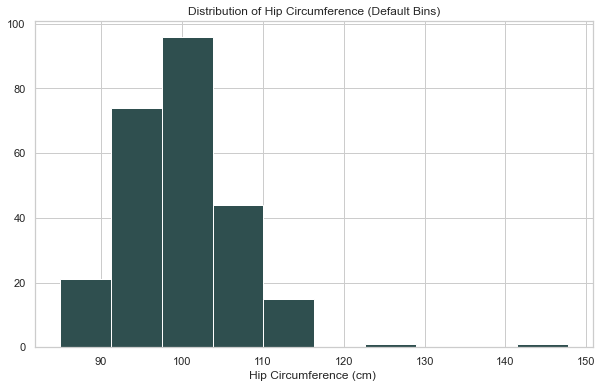

In [57]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(hip, color="darkslategray")
axes.set_title("Distribution of Hip Circumference (Default Bins)")
axes.set_xlabel("Hip Circumference (cm) ")

plt.show()
plt.close() 

This looks like the previous distributions that approximate a normal distribution with a right skew and a few outliers. Let's examine the outlier with the largest hips. 

In [58]:
query = """
SELECT *
FROM Body_Fat
WHERE Hip > 140
"""
result = list(con.execute(query))
tabulate(result, headers = ["ID", "Body Fat", "Density", "Age",
                            "Height", "Weight", "Neck", "Chest",
                            "Abdomen", "Hip", "Thigh", "Knee",
                            "Ankle", "Biceps", "Forearm", "Wrist"],  tablefmt='html')

,ID,Body Fat,Density,Age,Height,Weight,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
39,35.2,33.8,1.0202,46,72.25,363.15,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45,29,21.4


It's our old friend from before who had a very large weight and girthy neck. This point may prove problematic for us if it proves to be influential. 

<a id="thigh"></a>
## Thigh

Thigh is a numeric variable, circumference of the thigh measured in cm. We should expect the thigh measurement to follow a normal distribution resembling the previous circumferences, that is with a right skew. 

In [59]:
query = """
SELECT thigh
FROM Body_Fat
"""
thigh = pd.DataFrame(con.execute(query), columns = ["Thigh"])

In [60]:
thigh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Thigh   252 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB


We have no non-null values.

In [61]:
thigh.describe()

,Thigh
count,252.000000
mean,59.405952
std,5.249952
min,47.200000
25%,56.000000
50%,59.000000
75%,62.350000
max,87.300000


The mean [59.4] and median [59] are nearly the same. The scaled IQR ranges [2.9, 1, 1.1, 8.3] indicate the last quartile is more than 2 times the first. We should expect a long tails on the right again.

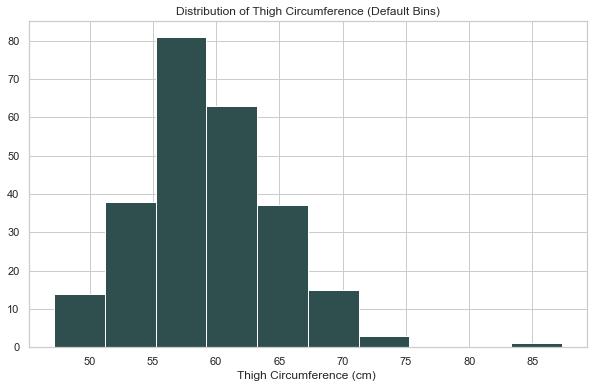

In [62]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(thigh, color="darkslategray")
axes.set_title("Distribution of Thigh Circumference (Default Bins)")
axes.set_xlabel("Thigh Circumference (cm) ")

plt.show()
plt.close()

The histogram is pretty symmetrical and normal looking but we do have the one outlier all the way to the right which is influencing the IQR range. 

<a id="knee"></a>
## Knee

Knee is a numeric variable, circumference of the knee measured in cm. We should expect the knee measurement to follow a normal distribution resembling the previous circumferences, that is with a right skew. 

In [63]:
query = """
SELECT knee
FROM Body_Fat
"""
knee = pd.DataFrame(con.execute(query), columns = ["Knee"])

In [64]:
knee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Knee    252 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB


We have no null values.

In [65]:
knee.describe()

,Knee
count,252.000000
mean,38.590476
std,2.411805
min,33.000000
25%,36.975000
50%,38.500000
75%,39.925000
max,49.100000


The mean [38.59] and median [38.5] are nearly the same. The scaled IQR ranges [2.8, 1.1, 1, 6] indicate the last quartile is more than 2 times the first. We should expect a long tails on the right again.

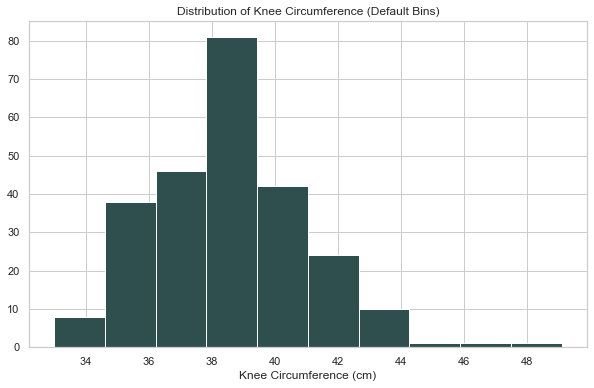

In [66]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(knee, color="darkslategray")
axes.set_title("Distribution of Knee Circumference (Default Bins)")
axes.set_xlabel("Knee Circumference (cm)")

plt.show()
plt.close() 

This distribution looks more squat than the previous normal distributions. We do however have evidence of the right tail. 

<a id="ankle"></a>
## Ankle

Ankle is a numeric variable, circumference of the ankle measured in cm. We should expect the ankle measurement to follow a normal distribution resembling the previous circumferences, that is with a right skew. 

In [67]:
query = """
SELECT ankle
FROM Body_Fat
"""
ankle = pd.DataFrame(con.execute(query), columns = ["Ankle"])

In [68]:
ankle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ankle   252 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB


We have no non-null values.

In [69]:
ankle.describe()

,Ankle
count,252.000000
mean,23.102381
std,1.694893
min,19.100000
25%,22.000000
50%,22.800000
75%,24.000000
max,33.900000


The mean [23.1] and median [22.8] are nearly the same. The scaled IQR ranges [3.6, 1, 1.5, 12.4] indicate the last quartile is more than 3 times the first. We should expect a long tails on the right again or a single large outlier.

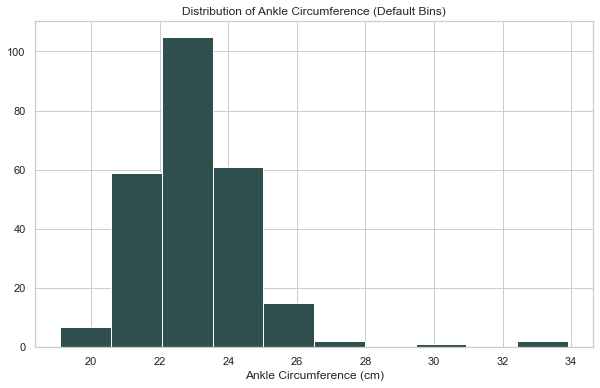

In [70]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(ankle, color="darkslategray")
axes.set_title("Distribution of Ankle Circumference (Default Bins)")
axes.set_xlabel("Ankle Circumference (cm)")

plt.show()
plt.close()

This resembles the thigh distribution. We have a very normal looking distribution with small standard deviation and a handful of outliers. 

<a id="biceps"></a>
## Biceps

Biceps is a numeric variable, circumference of the biceps measured in cm. We should expect the biceps measurement to follow a normal distribution resembling the previous circumferences, that is with a right skew. 

In [71]:
query = """
SELECT biceps
FROM Body_Fat
"""
biceps = pd.DataFrame(con.execute(query), columns = ["Biceps"])

In [72]:
biceps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Biceps  252 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB


We have no null values.

In [73]:
biceps.describe()

,Biceps
count,252.000000
mean,32.273413
std,3.021274
min,24.800000
25%,30.200000
50%,32.050000
75%,34.325000
max,45.000000


The mean [32.3] and median [32.1] are nearly the same. The scaled IQR ranges [3, 1, 1.2, 5.8] indicate the last quartile is more than almost 2 times the first. We should expect a long tails on the right again or a single large outlier.

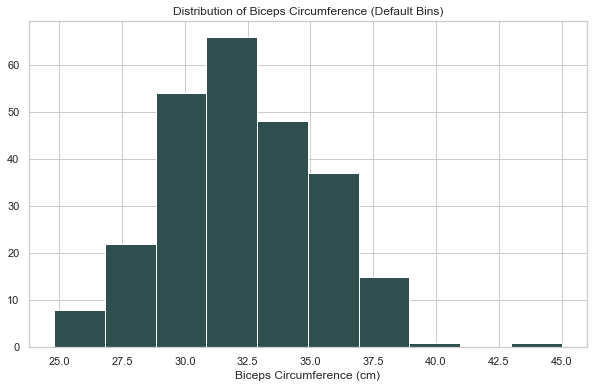

In [74]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(biceps, color="darkslategray")
axes.set_title("Distribution of Biceps Circumference (Default Bins)")
axes.set_xlabel("Biceps Circumference (cm)")

plt.show()
plt.close() 

We have a single outlier and evidence of a right skew, but the distribution looks otherwise like its approximating a normal distribution.

<a id="forearm"></a>
## Forearm

Forearm is a numeric variable, circumference of the forearm measured in cm. We should expect the forearm measurement to follow a normal distribution resembling the previous circumferences, that is with a right skew. 

In [75]:
query = """
SELECT forearm
FROM Body_Fat
"""
forearm = pd.DataFrame(con.execute(query), columns = ["Forearm"])

In [76]:
forearm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Forearm  252 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB


We have no null values.

In [77]:
forearm.describe()

,Forearm
count,252.000000
mean,28.663889
std,2.020691
min,21.000000
25%,27.300000
50%,28.700000
75%,30.000000
max,34.900000


The mean [28.7] is slightly larger than the median [28.7]. The scaled IQR ranges [4.8, 1.1, 1, 3.8] indicate the last quartile is more than about the same as the first. We should expect a symmetrical distribution.

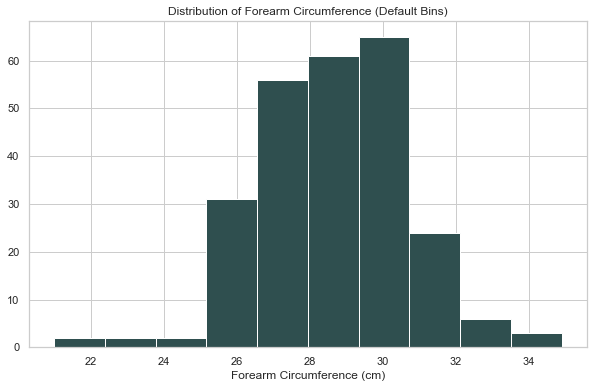

In [78]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(forearm, color="darkslategray")
axes.set_title("Distribution of Forearm Circumference (Default Bins)")
axes.set_xlabel("Forearm Circumference (cm)")

plt.show()
plt.close()

As opposed to before now we have a left skew with tails on the left. This is very interesting in that its the only circumference thus far with a left skew normal distribution.

<a id="wrist"></a>
## Wrist

Wrist is a numeric variable, circumference of the forearm measured in cm. We should expect the wrist measurement to follow a normal distribution resembling the previous circumferences, that is with a right skew.

In [79]:
query = """
SELECT wrist
FROM Body_Fat
"""
wrist = pd.DataFrame(con.execute(query), columns = ["Wrist"])

In [80]:
wrist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Wrist   252 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB


We have no null values.

In [81]:
wrist.describe()

,Wrist
count,252.000000
mean,18.229762
std,0.933585
min,15.800000
25%,17.600000
50%,18.300000
75%,18.800000
max,21.400000


The mean [18.2] is about the same as the median [18.3]. The scaled IQR ranges [3.6, 1.4, 1, 5.2] indicate the last quartile is about 1.5 the size as the first. We should expect a right skew.

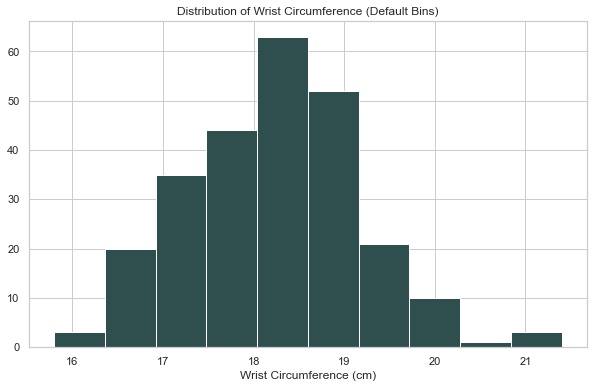

In [82]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(wrist, color="darkslategray")
axes.set_title("Distribution of Wrist Circumference (Default Bins)")
axes.set_xlabel("Wrist Circumference (cm)")

plt.show()
plt.close()

Our distribution approximates a normal one with a slight skew to the right. 

## Body Fat v. ?

As we have just seen, the Body Fat data has a very regular distribution, but most of the circumference measurements have right skews. Now we wille examine the relationships between the 14 variables and the target variable.

* [density](#v_density)
* [age](#v_age)
* [weight](#v_weight)
* [height](#v_height)
* [neck](#v_neck)
* [chest](#v_chest)
* [abdomen](#v_abdomen)
* [hip](#v_hip)
* [thigh](#v_thigh)
* [knee](#v_knee)
* [ankle](#v_ankle)
* [biceps](#v_biceps)
* [forearm](#v_forearm)
* [wrist](#v_wrist)

To help guide our expecations, we'll make a causal loop diagram.

In [83]:
Image(url="csd.png")

We exepct all the circumference measurements, weight, height and age to increase [as body fat increases]((https://www.researchgate.net/profile/Jorge-Mota-8/publication/47813165_Accuracy_of_Siri_and_Brozek_equations_in_the_percent_body_fat_estimation_in_older_adults/links/0046351557ebd6fe68000000/Accuracy-of-Siri-and-Brozek-equations-in-the-percent-body-fat-estimation-in-older-adults.pdf)). Density which we used to calculate Body Fat using Brozek's equation will have an inverse, nonlinear relationship with Body Fat.

For easier compuation, let's combine all our data into one dataframe.

In [84]:
body_fat = pd.DataFrame()
body_fat = pd.concat([bodyfat, density, age, weight, height, neck, chest, abdomen,
                    hip, thigh, knee, ankle, biceps, forearm, wrist], axis=1)
body_fat.head()

,BodyFat,BF_Group,Density,Age,Age_Group,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,12.6,Athletic,1.0708,23,20,154.25,172.085,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,6.9,Athletic,1.0853,22,20,173.25,183.515,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,24.6,Obese,1.0414,22,20,154.00,168.275,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,10.9,Athletic,1.0751,26,20,184.75,183.515,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,27.8,Obese,1.0340,24,20,184.25,180.975,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


In [85]:
body_fat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   BodyFat    252 non-null    float64
 1   BF_Group   252 non-null    object 
 2   Density    252 non-null    float64
 3   Age        252 non-null    int64  
 4   Age_Group  252 non-null    int64  
 5   Weight     252 non-null    float64
 6   Height     252 non-null    float64
 7   Neck       252 non-null    float64
 8   Chest      252 non-null    float64
 9   Abdomen    252 non-null    float64
 10  Hip        252 non-null    float64
 11  Thigh      252 non-null    float64
 12  Knee       252 non-null    float64
 13  Ankle      252 non-null    float64
 14  Biceps     252 non-null    float64
 15  Forearm    252 non-null    float64
 16  Wrist      252 non-null    float64
dtypes: float64(14), int64(2), object(1)
memory usage: 33.6+ KB


Great we have no issues so we may begin our pair wise analysis.

<a id="v_density"></a>

## Body Fat v. Density

We calculated Body Fat directly from Density. In Brozek's equation the relationship between Body Fat (BF) and Density (D) is 1/D. Therefore as D increases BF drops and vice versa. This relationship have a high spearman correlation. 

In [86]:
print("r   = ", stats.pearsonr( body_fat.BodyFat, body_fat.Density)[0])
print("rho = ", stats.spearmanr( body_fat.BodyFat, body_fat.Density)[0])

r   =  -0.9994497087287504
rho =  -0.9999816276720238


Both Pearson's and Spearman's correlation coefficient behave as expected. We have essentially a 1:1 inverse relationship. The exception being the point that we had to change from a negative value to 0. Let's plot the data:

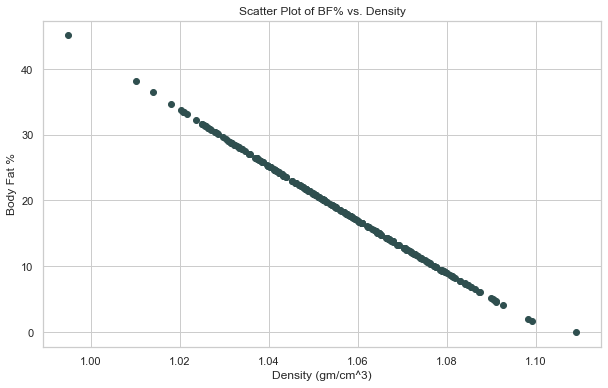

In [87]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( body_fat.Density, body_fat.BodyFat, marker="o", color="darkslategray")

axes.set_ylabel("Body Fat %")
axes.set_xlabel("Density (gm/cm^3)")
axes.set_title("Scatter Plot of BF% vs. Density")

plt.show()
plt.close() 

The relationship is perfectly linear due to Brozek's equation. The only reason why its not 100% is because of the negative value we had changed to 0. For obvious reasons we will not be using this to model our data.

<a id="v_age"></a>

## Body Fat v. Age

Age seems like it could be at least one explanatory variable for the different levels of body fat. [Older people have more brown adipose tissue which is even less than the fat younger people](https://www.researchgate.net/profile/Jorge-Mota-8/publication/47813165_Accuracy_of_Siri_and_Brozek_equations_in_the_percent_body_fat_estimation_in_older_adults/links/0046351557ebd6fe68000000/Accuracy-of-Siri-and-Brozek-equations-in-the-percent-body-fat-estimation-in-older-adults.pdf). Let's look first at correlation coefficients even though the relationship may not be linear or monotonic.

In [88]:
print("r   = ", stats.pearsonr( body_fat.BodyFat, body_fat.Age)[0])
print("rho = ", stats.spearmanr( body_fat.BodyFat, body_fat.Age)[0])

r   =  0.27840293984328063
rho =  0.26327895944575563


Pearson's correlation coefficient, $r$, is only 0.278 which indicates a fairly weak positive relationship. Spearman's is even weaker at 0.263 which might does not indicate that at least a medium monotonic relationship. Let's plot the data:

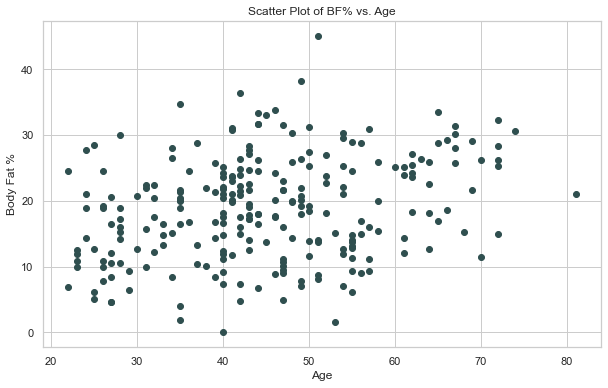

In [89]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( body_fat.Age, body_fat.BodyFat, marker="o", color="darkslategray")

axes.set_ylabel("Body Fat %")
axes.set_xlabel("Age")
axes.set_title("Scatter Plot of BF% vs. Age")

plt.show()
plt.close()

There may be a slight increase in body fat with age, however it's very difficult to see and may just be due to random error.

Let's try to group the age's into decades and see if we can tease out a relationship that way. We will use a helper function provided by Fundamentals. 

In [90]:
def describe_by_category(data, numeric, categorical, transpose=False):
    grouped = data.groupby(categorical)
    grouped_y = grouped[numeric].describe()
    if transpose:
        print(grouped_y.transpose())
    else:
        print(grouped_y)

In [91]:
describe_by_category(body_fat, "BodyFat", "Age_Group")

           count       mean       std   min     25%    50%     75%   max
Age_Group                                                               
20          38.0  14.521053  6.856725   4.6   9.900  12.70  19.000  30.1
30          54.0  17.329630  6.911315   0.0  12.625  17.55  21.950  34.7
40          84.0  20.419048  7.595774   4.8  16.000  20.15  24.925  38.2
50          41.0  17.834146  8.741442   1.6  11.900  15.10  24.500  45.1
60          28.0  23.089286  6.176199  11.5  18.350  24.65  27.325  33.5
70           7.0  25.557143  5.933480  15.0  23.200  26.20  29.500  32.3


The results are inconclusive however if there is a pattern it seems be increasing with age groups. Let's generate side by side histograms of body fat by age group.

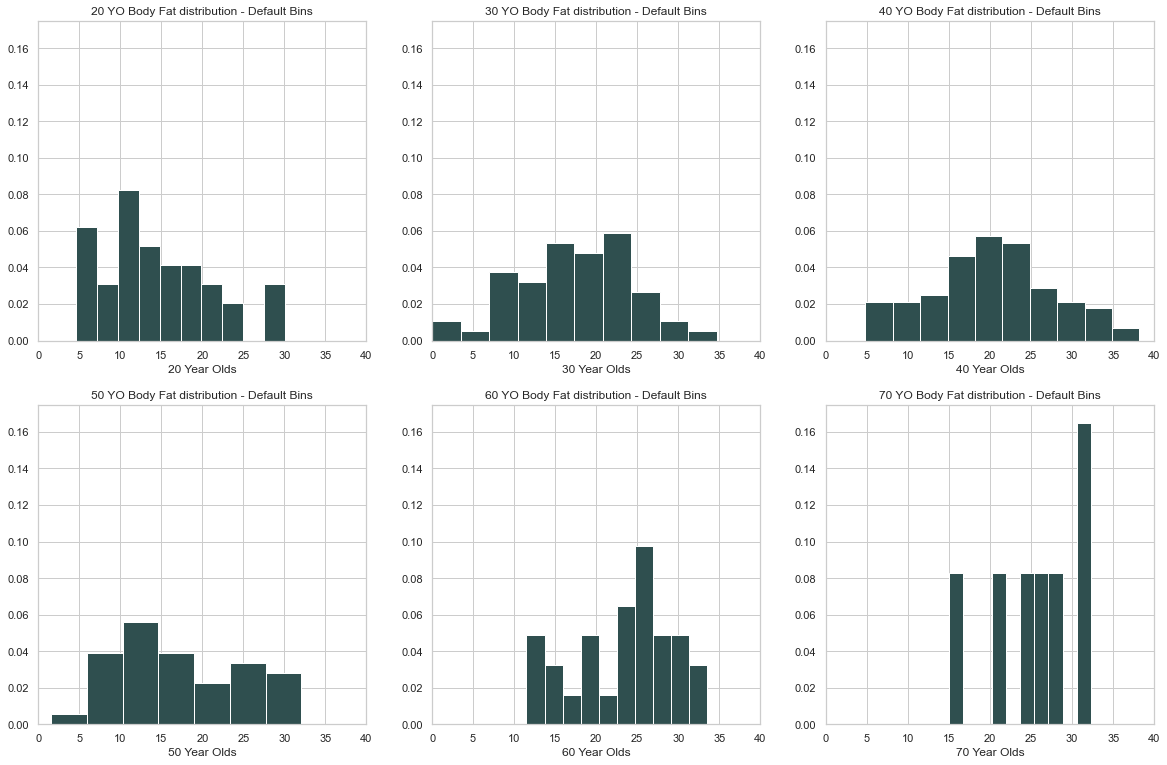

In [92]:
grouped = body_fat.groupby("Age_Group")

figure = plt.figure(figsize=(20, 20))

axes = figure.add_subplot(3, 3, 1)
axes.hist(grouped["BodyFat"].get_group(20),color="darkslategray",density=True)
axes.set_title("20 YO Body Fat distribution - Default Bins")
axes.set_xlabel("20 Year Olds")
axes.set_xlim((0,40))
axes.set_ylim((0,.175))

axes = figure.add_subplot(3, 3, 2)
axes.hist(grouped["BodyFat"].get_group(30),color="darkslategray",density=True)
axes.set_title("30 YO Body Fat distribution - Default Bins")
axes.set_xlabel("30 Year Olds")
axes.set_xlim((0,40))
axes.set_ylim((0,.175))

axes = figure.add_subplot(3, 3, 3)
axes.hist(grouped["BodyFat"].get_group(40),color="darkslategray",density=True)
axes.set_title("40 YO Body Fat distribution - Default Bins")
axes.set_xlabel("40 Year Olds")
axes.set_xlim((0,40))
axes.set_ylim((0,.175))

axes = figure.add_subplot(3, 3, 4)
axes.hist(grouped["BodyFat"].get_group(50),color="darkslategray",density=True)
axes.set_title("50 YO Body Fat distribution - Default Bins")
axes.set_xlabel("50 Year Olds")
axes.set_xlim((0,40))
axes.set_ylim((0,.175))

axes = figure.add_subplot(3, 3, 5)
axes.hist(grouped["BodyFat"].get_group(60),color="darkslategray",density=True)
axes.set_title("60 YO Body Fat distribution - Default Bins")
axes.set_xlabel("60 Year Olds")
axes.set_xlim((0,40))
axes.set_ylim((0,.175))

axes = figure.add_subplot(3, 3, 6)
axes.hist(grouped["BodyFat"].get_group(70),color="darkslategray",density=True)
axes.set_title("70 YO Body Fat distribution - Default Bins")
axes.set_xlabel("70 Year Olds")
axes.set_xlim((0,40))
axes.set_ylim((0,.175))

plt.show()
plt.close()

It almost as if 20 and 50 olds have the similar distributions, as do 30 and 40 year olds, and 60 and 70 year olds. If there is a pattern its very slight. 

<a id="v_weight"></a>

## Body Fat v. Weight

We should expect some level of correlation between weight and body fat. However, human weight is comprised of more than just fat. There are additional components such as water, bone and muscle. Therefore we should not expect a perfect correlation. There are some people for example who have big muscles and weigh a lot, but have low body fat percentages. We also have to remember that as a person gets larger, the supporting structure such as bones, water, and proteinacious tissues expand exponenitially as well. For these reasons, weight may not be the best predictor especially at larger weights. 

Let's look first at correlation coefficients.

In [93]:
print("r   = ", stats.pearsonr( body_fat.BodyFat, body_fat.Weight)[0])
print("rho = ", stats.spearmanr( body_fat.BodyFat, body_fat.Weight)[0])

r   =  0.5956451627422967
rho =  0.6016857035955114


Pearson's correlation coefficient, $r$, is 0.60 which indicates a medium positive relationship. Spearman's is also at .60 as well which might indicate that at least a medium monotonic relationship. Let's plot the data:

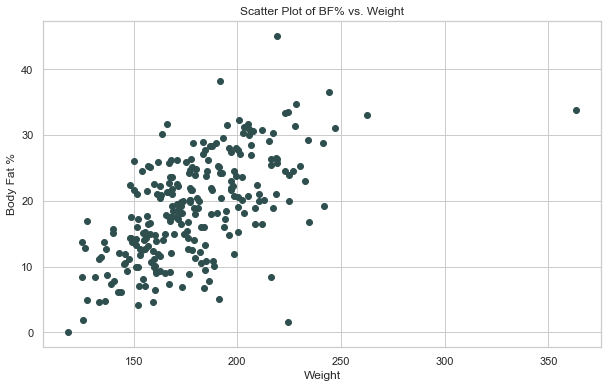

In [94]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( body_fat.Weight, body_fat.BodyFat, marker="o", color="darkslategray")

axes.set_ylabel("Body Fat %")
axes.set_xlabel("Weight")
axes.set_title("Scatter Plot of BF% vs. Weight")

plt.show()
plt.close()

There is definitely a positive relationship between weight and body fat. As expected we also have some very heavy people with low body fats and some very heavy people with high body fat. We should expect that people who exist on either side of these line have a difference in muscle tissue. 

We also see that one outlier all the way to the right, existing in a space we shouldn't expect it to. While I doubt this person with such a high body fat percentage is competing professionally, this does provide some insight into the relationship of weight and body fat. We have to bear in mind as person gets fatter, his or her body will need to increase muscle tissue in order to support the [added weight](https://sportsmedicine-open.springeropen.com/articles/10.1186/s40798-018-0125-4#:~:text=People%20who%20are%20overweight%20do,people%20who%20are%20not%20overweight.). This has the effect of slowing down the rate of increase of body fat. Therefore we should expect a sort of asymptopic relationship between body fat and weight. 

<a id="v_height"></a>

## Body Fat v. Height

By itself, there shouldn't be any real correlation between height and body fat. Fat people come in all heights. However, should we combine this measurement with other terms, such as abdomen circumference we should expect to find a better correlation.

Let's look first at correlation coefficients.

In [95]:
print("r   = ", stats.pearsonr( body_fat.BodyFat, body_fat.Height)[0])
print("rho = ", stats.spearmanr( body_fat.BodyFat, body_fat.Height)[0])

r   =  -0.10220423182175754
rho =  -0.013511170499601505


As expected there is a very weak, but slightly negative relationship.

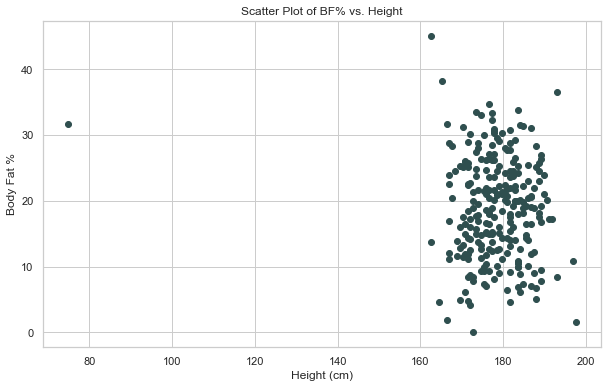

In [96]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( body_fat.Height, body_fat.BodyFat, marker="o", color="darkslategray")

axes.set_ylabel("Body Fat %")
axes.set_xlabel("Height (cm)")
axes.set_title("Scatter Plot of BF% vs. Height")

plt.show()
plt.close()

Ignoring the troublesome outlier, this plot reveals essentially no relationship between height and BF. 

We have enough information to calculate the BMI, so let's see if that correlates better with body fat. We should expect to be a better indicator than height alone, but have the same issue as weight as predictor, namely that it does differentiate between muscle and fat mass. 

In [97]:
body_fat["BMI"] = 10000*(body_fat["Weight"]/2.205/body_fat["Height"]**2)
body_fat.BMI.describe()

count    252.000000
mean      25.937780
std        9.556823
min       18.014595
25%       23.031737
50%       25.090013
75%       27.329891
max      165.589884
Name: BMI, dtype: float64

In [98]:
print("r   = ", stats.pearsonr( body_fat.BodyFat, body_fat.BMI)[0])
print("rho = ", stats.spearmanr( body_fat.BodyFat, body_fat.BMI)[0])

r   =  0.3680183621237295
rho =  0.7189619325573277


Pearson's correlation coefficient, $r$, is 0.36 which is between the weight and height and indicates a weak positive relationship. Spearman's is more interesting. At .71, it's much higher than weight and height, and as well might indicate that at least a medium monotonic relationship. This suggests that BMI's relationship with Body Fat is not linear. Let's plot the data:

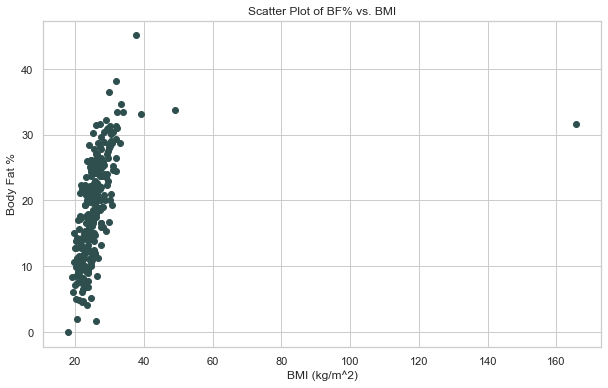

In [99]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( body_fat.BMI, body_fat.BodyFat, marker="o", color="darkslategray")

axes.set_ylabel("Body Fat %")
axes.set_xlabel("BMI (kg/m^2)")
axes.set_title("Scatter Plot of BF% vs. BMI")

plt.show()
plt.close()

The outlier (the person with the unrealistic height) is making it difficult to see the relationship. Let's replot without the outlier.

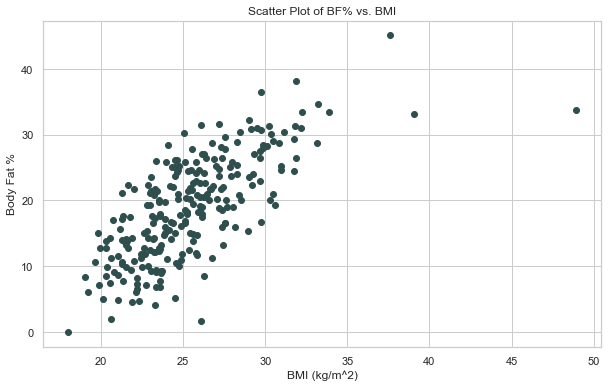

In [100]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( body_fat[body_fat["Height"] >75].BMI, 
             body_fat[body_fat["Height"] >75].BodyFat, marker="o", color="darkslategray")

axes.set_ylabel("Body Fat %")
axes.set_xlabel("BMI (kg/m^2)")
axes.set_title("Scatter Plot of BF% vs. BMI")

plt.show()
plt.close()

This relationship now resembles the weight category. Let's check the correlation coefficients again without the impossible observation.

In [101]:
print("r   = ", stats.pearsonr( body_fat[body_fat["Height"] >75].BodyFat, body_fat[body_fat["Height"] >75].BMI)[0])
print("rho = ", stats.spearmanr( body_fat[body_fat["Height"] >75].BodyFat, body_fat[body_fat["Height"] >75].BMI)[0])

r   =  0.715955239384459
rho =  0.7156890387608431


So we have fixed Pearson's coefficient (now at .71) and now the relationship is even better than weight alone. We will definitely be using this metric in our modeling. This also suggests that the relationship bewteen BMI and Body Fat is indeed linear. 

Before we move on, we should check one last derived feature (one that I've completely made up). This parameter compares height and abdomen size $abdomen/height$. Let's call it the waist to height ratio or ATH. My theory is that a person who has a higher ATH index will also have a higher BMI. This ratio I believe is superior to the BMI because unlike in BMI a person who has more muscle isn't necesarily going to have a high ATH index. This solves the issue we have hithero had with weight and height.

In [102]:
body_fat["ATH"] = body_fat["Abdomen"]/body_fat["Height"]
body_fat.ATH.describe()

count    252.000000
mean       0.521752
std        0.081444
min        0.396698
25%        0.475592
50%        0.514179
75%        0.552319
max        1.391966
Name: ATH, dtype: float64

In [103]:
print("r   = ", stats.pearsonr( body_fat[body_fat["Height"] >75].ATH, body_fat[body_fat["Height"] >75].BodyFat)[0])
print("rho = ", stats.spearmanr( body_fat[body_fat["Height"] >75].ATH, body_fat[body_fat["Height"] >75].BodyFat)[0])

r   =  0.8250280430524694
rho =  0.828110554698028


The ATH ratio has the most superior Pearson (83) and Spearman's (83) coefficient so far. We theorized this is due to the ATH not being impacted by a person's muscle mass. The equality of these two factors also suggests a linear relationship.

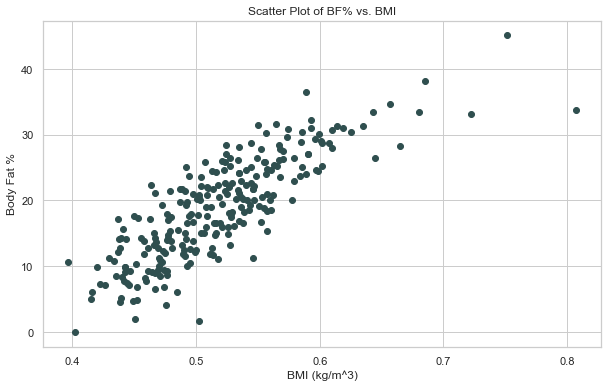

In [104]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( body_fat[body_fat["Height"] >75].ATH, 
             body_fat[body_fat["Height"] >75].BodyFat, marker="o", color="darkslategray")

axes.set_ylabel("Body Fat %")
axes.set_xlabel("BMI (kg/m^3)")
axes.set_title("Scatter Plot of BF% vs. BMI")

plt.show()
plt.close()

This is our clearest association so far. It could be linear or slightly logarithmic.

<a id="v_neck"></a>

## Body Fat v. Neck

We now begin our foray into the relationship between circumference measurement and body fat. There are two things to note while we investigate the relationships.

Earlier we stated how muscle mass can complicate the relationship between weight and body fat since a heavier person is not necessarily fatter. That issue applies here as well. Someone how has a larger chest for example isn't necessarily more fat; he could have a larger chest from habitually bench pressing. Therefore we should distinguish measurements around body parts with a lot of muscle mass (ie, thigh) from those without muscle (ie. wrist). We theorize that former will not have as strong correlations to body fat as the latter. Since the neck isn't a highly muscular structure (as in everyone head roughly weighs the same), this measurement should be one of the stronger correlators. 

Secondly, just because someone has a larger wrist doesn't mean they are fatter. They could just be a taller person. Therefore it will probably be a good idea to "standardize" most of circumference measurements by the indviduals height. In this fashion we can distinguish a large wrist due to someone being tall vs someone being fat. To this end, we should probably remove that observation with the impossible height of 29 inches before we delve into all the relationships.

We begin by addressing the troublesome data point so that the "scaled" values aren't messed up by the impossible height value. We could try to impute it, however, I'd rather just drop it as this whole row has some wacky numbers.  

In [105]:
body_fat2 = body_fat.drop(index = 41)
body_fat2[body_fat2.Height < 75]

,BodyFat,BF_Group,Density,Age,Age_Group,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,BMI,ATH


Finally we can resume out analysis of Neck vs. Body Fat.

Now let's look first at correlation coefficients even though the relationship may not be linear or monotonic.

In [106]:
print("r   = ", stats.pearsonr( body_fat2.Neck, body_fat2.BodyFat)[0])
print("rho = ", stats.spearmanr( body_fat2.Neck, body_fat2.BodyFat)[0])

r   =  0.48097460442520285
rho =  0.4874409730520584


Both the Pearson's (.48) and Spearman's (.49) are mildly predictive. The fact that they are equal suggests the relatioship is linear. Let's examine the scatterplot. 

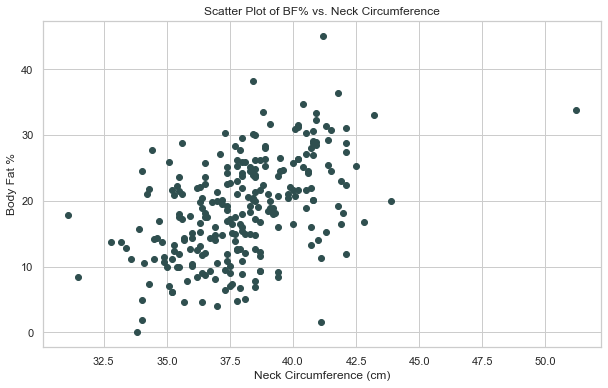

In [107]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( body_fat2.Neck, 
             body_fat2.BodyFat, marker="o", color="darkslategray")

axes.set_ylabel("Body Fat %")
axes.set_xlabel("Neck Circumference (cm)") 
axes.set_title("Scatter Plot of BF% vs. Neck Circumference")

plt.show()
plt.close()

The correlation is faint but definitely there. The range of neck sizes is so short that a small increase in neck size has a dramatic impact on the response. There also seems to be very high variability as well. Let's "standardize" the neck by height and see if that improves the relationship.

In [108]:
body_fat2["NTH"] = (body_fat["Neck"])/body_fat["Height"]
body_fat2.NTH.describe()

count    251.000000
mean       0.212897
std        0.013413
min        0.178746
25%        0.203468
50%        0.212890
75%        0.221748
max        0.278996
Name: NTH, dtype: float64

In [109]:
print("r   = ", stats.pearsonr( body_fat2.NTH, body_fat2.BodyFat)[0])
print("rho = ", stats.spearmanr( body_fat2.NTH, body_fat2.BodyFat)[0])

r   =  0.5178834220861285
rho =  0.49307074408753376


This did not improve Pearson's (.51) and Spearmans (.49) coefficient has only improved slightly, and so standardizes the neck circumference with the height, unlike with the abdomen doesn't improve the correlation. Perhaps people simply do not gain weight in their necks in a matter very proportional to the rest of their bodies. 

<a id="v_chest"></a>

## Body Fat v. Chest

A person's chest may be large due to bench pressing or it might be large due to fat storage. We shouldn't expect this circumference to be as predictive as an area of the body that only gets larger with fat such as the abdomen. We begin by exploring the correlation coefficients. 

In [110]:
print("r   = ", stats.pearsonr( body_fat2.Chest, body_fat2.BodyFat)[0])
print("rho = ", stats.spearmanr( body_fat2.Chest, body_fat2.BodyFat)[0])

r   =  0.6847833045449288
rho =  0.661329167915596


Surprisngly chest does in fact seem to correlate more strongly with body fat than neck circumference. Pearson's coefficient (.68) and Spearman's coefficient (.66) do indicate a moderate relationship between chest size and body fat. Let's examine the scatterplot.

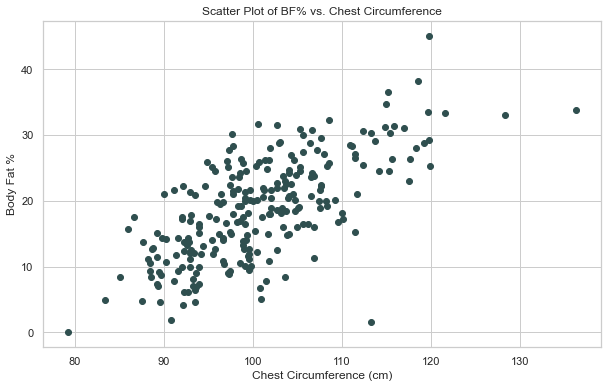

In [111]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( body_fat2.Chest, 
             body_fat2.BodyFat, marker="o", color="darkslategray")

axes.set_ylabel("Body Fat %")
axes.set_xlabel("Chest Circumference (cm)")
axes.set_title("Scatter Plot of BF% vs. Chest Circumference")

plt.show()
plt.close() 

We see a similar positive linear relationship between chest and body fat. Of note the variance is much smaller than in the neck scatterplot. 

Let's see if we can improve correlation if we include our "standardized" special.

In [112]:
body_fat2["CTH"] = body_fat["Chest"]/body_fat["Height"]
body_fat2.CTH.describe()

count    251.000000
mean       0.564827
std        0.047530
min        0.459125
25%        0.533673
50%        0.558339
75%        0.589937
max        0.742174
Name: CTH, dtype: float64

In [113]:
print("r   = ", stats.pearsonr( body_fat2.CTH, body_fat2.BodyFat)[0])
print("rho = ", stats.spearmanr( body_fat2.CTH, body_fat2.BodyFat)[0])

r   =  0.7081386703934401
rho =  0.6836832074342364


The improvement in Pearson's (.71) and Spearman's (.68) is only slight as before. Let's compare it to the histogram.

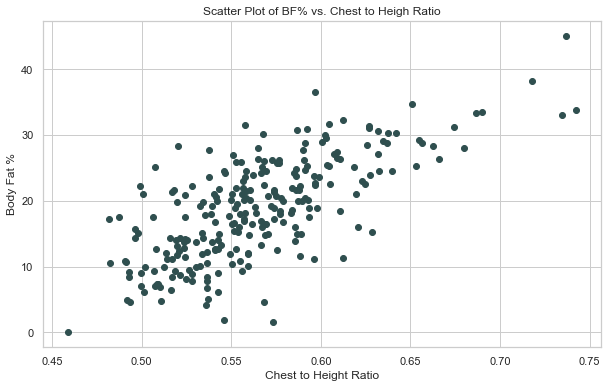

In [114]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( body_fat2.CTH, 
             body_fat2.BodyFat, marker="o", color="darkslategray")

axes.set_ylabel("Body Fat %")
axes.set_xlabel("Chest to Height Ratio")
axes.set_title("Scatter Plot of BF% vs. Chest to Heigh Ratio")

plt.show()
plt.close()

We can see that this does indeed improve the relationship between chest and body fat percentage. It's positive and linear as expected. What this tells us is that while not all the variability in chest size is attributable to body fat, a large percentage of it is, especially when scaling the chest by the person's height.

<a id="v_abdomen"></a>

## Body Fat v. Abdomen

Earlier we examined the relationship of abdomen/height to body fat. Now we can examine the relationship of just the circumference of the abodmen to body fat. The only real way to increase the size of one's abdomen is by adding fat, so we should expect this variable to have a moderate to strong correlation with body fat.

In [115]:
print("r   = ", stats.pearsonr( body_fat2.Abdomen, body_fat2.BodyFat)[0])
print("rho = ", stats.spearmanr( body_fat2.Abdomen, body_fat2.BodyFat)[0])

r   =  0.8008523634900282
rho =  0.8061385583158468


As expected both Pearson's (.80) and Spearman's (.81) are high (though not as high as abdomen/height), indicating that these are pretty strong indicators of body fat. Let's plot the relationship.

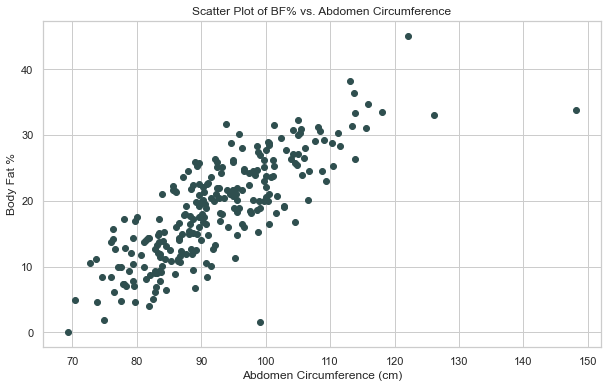

In [116]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( body_fat2.Abdomen, 
             body_fat2.BodyFat, marker="o", color="darkslategray")

axes.set_ylabel("Body Fat %")
axes.set_xlabel("Abdomen Circumference (cm)")
axes.set_title("Scatter Plot of BF% vs. Abdomen Circumference")

plt.show()
plt.close()

This plot is has very tight variance and is somewhat more linear than the abdomen/height plot which looked slightly logarithmic. Adbdomen circumference has the single best correlation with the Body Fat of any single variable so far. 

<a id="v_hip"></a>

## Body Fat v. Hip

We should expect that hip, a bony area with no muscle, to be a good indicator for body fat percentage. We will check it against body fat as well when it is scaled with height. From this measurement onward we will compare the unscaled and scaled measurements side by side for easier comparison.

In [117]:
body_fat2["HTH"] = body_fat["Hip"]/body_fat["Height"]

In [118]:
print("unscaled r   = ", stats.pearsonr( body_fat2.Hip, body_fat2.BodyFat)[0])
print("unscaled rho = ", stats.spearmanr( body_fat2.Hip, body_fat2.BodyFat)[0])
print("scaled r   = ", stats.pearsonr( body_fat2.HTH, body_fat2.BodyFat)[0])
print("scaled rho = ", stats.spearmanr( body_fat2.HTH, body_fat2.BodyFat)[0])

unscaled r   =  0.6064162315771153
unscaled rho =  0.5967970287735666
scaled r   =  0.6758991362531376
scaled rho =  0.6683773327808676


Pearsons (.61) and Spearmans (.60) are moderate correlators to body fat. Scaling the hip circumference to height improves the correlation but not as strongly as the abdomen measurement. The fact thar Pearson's and Spearmans are nearly equal indicate a linear relationship if any.

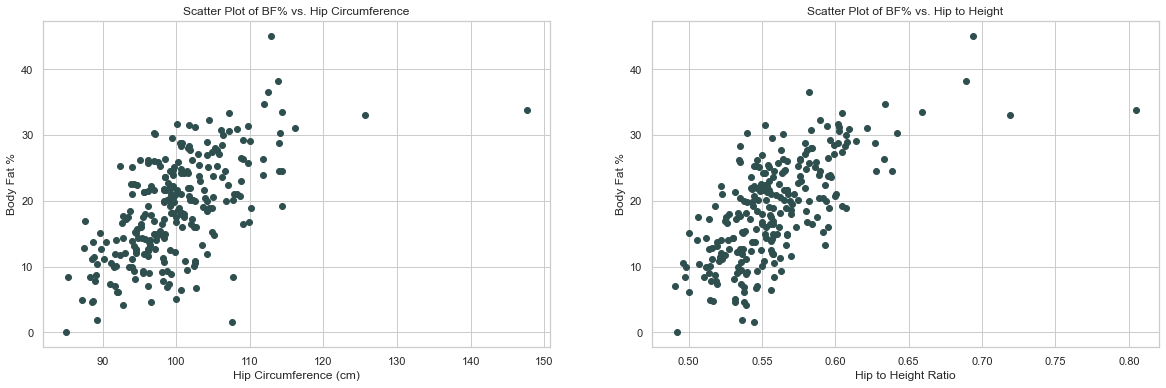

In [119]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 2, 1)
axes.scatter( body_fat2.Hip, 
             body_fat2.BodyFat, marker="o", color="darkslategray")

axes.set_ylabel("Body Fat %")
axes.set_xlabel("Hip Circumference (cm)")
axes.set_title("Scatter Plot of BF% vs. Hip Circumference")


axes = figure.add_subplot(1, 2, 2)
axes.scatter( body_fat2.HTH, 
             body_fat2.BodyFat, marker="o", color="darkslategray")

axes.set_ylabel("Body Fat %")
axes.set_xlabel("Hip to Height Ratio")
axes.set_title("Scatter Plot of BF% vs. Hip to Height")

plt.show()
plt.close()

We can see a positive relationship between between hip circumference and body fat. This relationship is more significantly visible when scaled by height. We do see evidence of a logarthmic relationship between Hip/Height and Body Fat percentage.

Let's try one more derived variable. An increased Abdomen to Hip ratio is correlated with high [morbidity](https://en.wikipedia.org/wiki/Waist%E2%80%93hip_ratio). Naturally we should examine if there is also a relationship between this ABTH and body fat percentage.

In [120]:
body_fat2["ABTH"] = body_fat["Abdomen"]/body_fat["Hip"]

In [121]:
print("unscaled r   = ", stats.pearsonr( body_fat2.ABTH, body_fat2.BodyFat)[0])
print("unscaled rho = ", stats.spearmanr( body_fat2.ABTH, body_fat2.BodyFat)[0])

unscaled r   =  0.7748101923576762
unscaled rho =  0.7759359302086906


The Abdomen to Hip ratio is clearly very stronlgy correlated with body fat percentage (Pearsons = Spearmans = .77). This correlation is only slightly less strong as the abdomen to height ratio. 

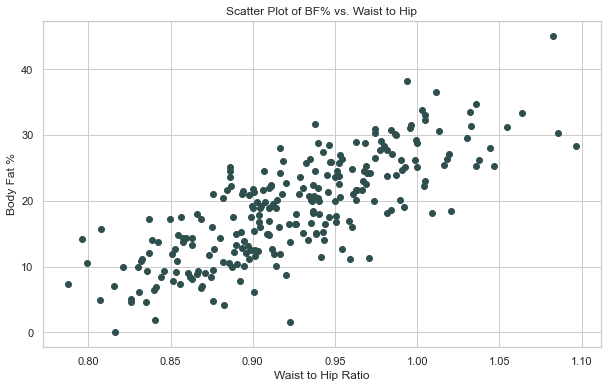

In [122]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( body_fat2.ABTH, 
             body_fat2.BodyFat, marker="o", color="darkslategray")

axes.set_ylabel("Body Fat %")
axes.set_xlabel("Waist to Hip Ratio")
axes.set_title("Scatter Plot of BF% vs. Waist to Hip")

plt.show()
plt.close()

This relationship is remarkably positive and linear. We know that the Waist to Hip ratio is very predictive or morbidity, but it also looks fairly predictive of body fat percentage as well.

<a id="v_thigh"></a>

## Body Fat v. Thigh

Because thighs can be fairly muscular or fat, we should expect the circumference of a thigh to have a similar relationship to body fat as the chest.

In [123]:
body_fat2["TTH"] = body_fat["Thigh"]/body_fat["Height"]

In [124]:
print("unscaled r   = ", stats.pearsonr( body_fat2.Thigh, body_fat2.BodyFat)[0])
print("unscaled rho = ", stats.spearmanr( body_fat2.Thigh, body_fat2.BodyFat)[0])
print("scaled r   = ", stats.pearsonr( body_fat2.TTH, body_fat2.BodyFat)[0])
print("scaled rho = ", stats.spearmanr( body_fat2.TTH, body_fat2.BodyFat)[0])

unscaled r   =  0.5461645450826595
unscaled rho =  0.5323877113791461
scaled r   =  0.6028885120562288
scaled rho =  0.5849808695165472


Pearson's (.55) and Spearmans (.53) in the unscaled circumferences are mildly correlated with body fat, though not as strong as chest measurements, but better than than the neck circumference relationship. After scaling it with the patient's height, we can see that both Pearson's (.60) and Spearman's (.58) improve slightly. Let's also examine the resulting histograms.

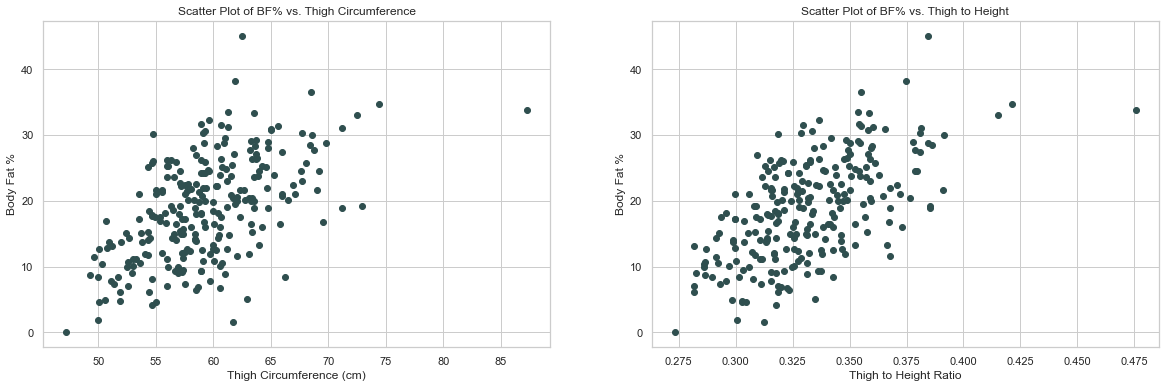

In [125]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 2, 1)
axes.scatter( body_fat2.Thigh, 
             body_fat2.BodyFat, marker="o", color="darkslategray")

axes.set_ylabel("Body Fat %")
axes.set_xlabel("Thigh Circumference (cm)")
axes.set_title("Scatter Plot of BF% vs. Thigh Circumference")


axes = figure.add_subplot(1, 2, 2)
axes.scatter( body_fat2.TTH, 
             body_fat2.BodyFat, marker="o", color="darkslategray")

axes.set_ylabel("Body Fat %")
axes.set_xlabel("Thigh to Height Ratio")
axes.set_title("Scatter Plot of BF% vs. Thigh to Height")

plt.show()
plt.close()

We can see that the relationship is positive but we still see some variation. Scaling the thigh with height does decrease the varaition, but now the relationship looks linear or slightly logarthmic. 

<a id="v_knee"></a>

## Body Fat v. Knee

We should expect that the circumference of the knee, a relatively muscleless joint, to only increase in size by fat.

In [126]:
body_fat2["KTH"] = body_fat["Knee"]/body_fat["Height"]
body_fat2.KTH.describe()

count    251.000000
mean       0.216043
std        0.011660
min        0.191008
25%        0.207798
50%        0.214259
75%        0.223655
max        0.267553
Name: KTH, dtype: float64

In [127]:
print("unscaled r   = ", stats.pearsonr( body_fat2.Knee, body_fat2.BodyFat)[0])
print("unscaled rho = ", stats.spearmanr( body_fat2.Knee, body_fat2.BodyFat)[0])
print("scaled r   = ", stats.pearsonr( body_fat2.KTH, body_fat2.BodyFat)[0])
print("scaled rho = ", stats.spearmanr( body_fat2.KTH, body_fat2.BodyFat)[0])

unscaled r   =  0.488181690694477
unscaled rho =  0.4746490972557879
scaled r   =  0.5936795411245673
scaled rho =  0.5759454419222109


Pearsons (.49) and Spearmans(.47) indicate knee circumference is only moderately predictive, though scaling it by the height does improve this ratio significantly (by about 10 percentage points). 

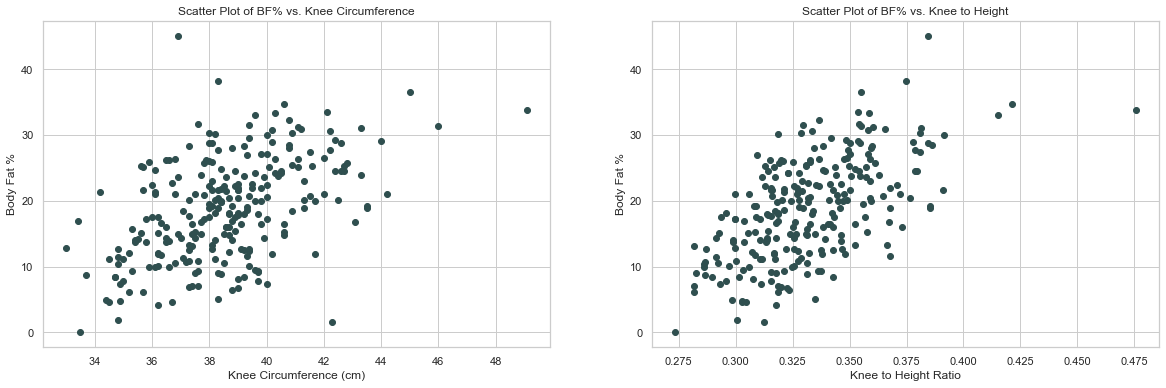

In [128]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 2, 1)
axes.scatter( body_fat2.Knee, 
             body_fat2.BodyFat, marker="o", color="darkslategray")

axes.set_ylabel("Body Fat %")
axes.set_xlabel("Knee Circumference (cm)")
axes.set_title("Scatter Plot of BF% vs. Knee Circumference")


axes = figure.add_subplot(1, 2, 2)
axes.scatter( body_fat2.TTH, 
             body_fat2.BodyFat, marker="o", color="darkslategray")

axes.set_ylabel("Body Fat %")
axes.set_xlabel("Knee to Height Ratio")
axes.set_title("Scatter Plot of BF% vs. Knee to Height")

plt.show()
plt.close()

As before the relationship between body fat and Knee is linear; and scaling factor tightens the variability but makes it look more logarithmic.

<a id="v_ankle"></a>

## Body Fat v. Ankle

We should expect that the circumference of the ankle, a relatively skeletal joint, to only increase in size by fat. As such, the relationship should mirror other bony measurements and not be very predictive.

In [129]:
body_fat2["AKTH"] = body_fat["Ankle"]/body_fat["Height"]
body_fat2.AKTH.describe()

count    251.000000
mean       0.129387
std        0.008816
min        0.113532
25%        0.124342
50%        0.128129
75%        0.133379
max        0.196559
Name: AKTH, dtype: float64

In [130]:
print("unscaled r   = ", stats.pearsonr( body_fat2.Ankle, body_fat2.BodyFat)[0])
print("unscaled rho = ", stats.spearmanr( body_fat2.Ankle, body_fat2.BodyFat)[0])
print("scaled r   = ", stats.pearsonr( body_fat2.AKTH, body_fat2.BodyFat)[0])
print("scaled rho = ", stats.spearmanr( body_fat2.AKTH, body_fat2.BodyFat)[0])

unscaled r   =  0.2635054353275059
unscaled rho =  0.2947295518629097
scaled r   =  0.3108917876479995
scaled rho =  0.3154293186915388


Pearson's(.26) and Spearmans (.29) both indicate a weak relationship between body fat and ankle circumference. The scaling helps but only slightly. This variable is only slightly more predictive than age, so we should expect their scatterplots to have large variation and probably no obvious correlations.

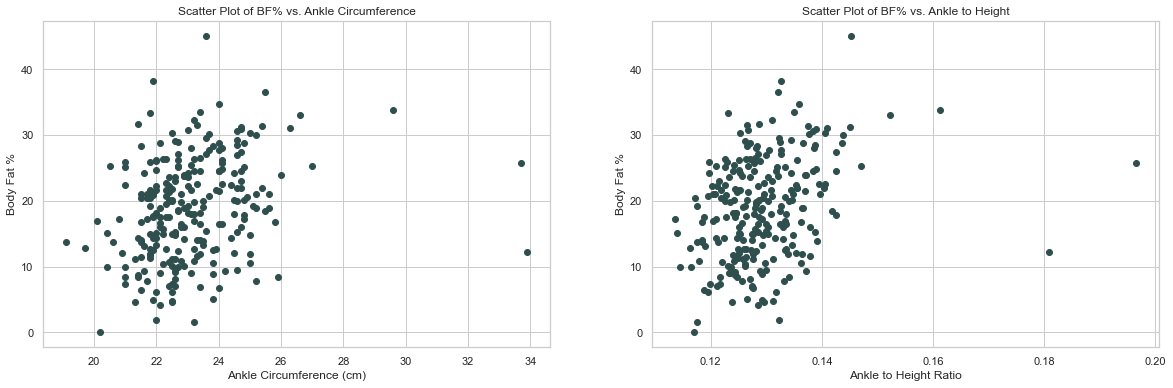

In [131]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 2, 1)
axes.scatter( body_fat2.Ankle, 
             body_fat2.BodyFat, marker="o", color="darkslategray")

axes.set_ylabel("Body Fat %")
axes.set_xlabel("Ankle Circumference (cm)")
axes.set_title("Scatter Plot of BF% vs. Ankle Circumference")


axes = figure.add_subplot(1, 2, 2)
axes.scatter( body_fat2.AKTH, 
             body_fat2.BodyFat, marker="o", color="darkslategray")

axes.set_ylabel("Body Fat %")
axes.set_xlabel("Ankle to Height Ratio")
axes.set_title("Scatter Plot of BF% vs. Ankle to Height")

plt.show()
plt.close()

We can definitely see a relationship between ankle circumference and body fat percentage with better resolution in the second plot. The bad correlation is perhaps due to the two outliers but we can definitely see that as we increase scaled ankle circumference body body fat % also increases. The ankle does not seem to be a place in the body that deposits a fat in proportion to the rest of the body. 

<a id="v_biceps"></a>

## Body Fat v. Biceps

The biceps are a muscular area of the body. We should therefore expect the relationship between body fat and its circumference to behave similarly to chest and thigh.

In [132]:
body_fat2["BTH"] = body_fat["Biceps"]/body_fat["Height"]
body_fat2.BTH.describe()

count    251.000000
mean       0.180733
std        0.016093
min        0.140103
25%        0.169994
50%        0.180054
75%        0.192668
max        0.245212
Name: BTH, dtype: float64

In [133]:
print("unscaled r   = ", stats.pearsonr( body_fat2.Biceps, body_fat2.BodyFat)[0])
print("unscaled rho = ", stats.spearmanr( body_fat2.Biceps, body_fat2.BodyFat)[0])
print("scaled r   = ", stats.pearsonr( body_fat2.BTH, body_fat2.BodyFat)[0])
print("scaled rho = ", stats.spearmanr( body_fat2.BTH, body_fat2.BodyFat)[0])

unscaled r   =  0.4866265376036417
unscaled rho =  0.4876391439350549
scaled r   =  0.5333167551654192
scaled rho =  0.5162991832038766


Pearsons (.49) and Spearmans (.48) only moderately correlate, mostly matching the thigh and not as strong as the chest or abdomen. Unlike the thigh however, scaling the bicep circumference by height does not improve either correlation as strongly.

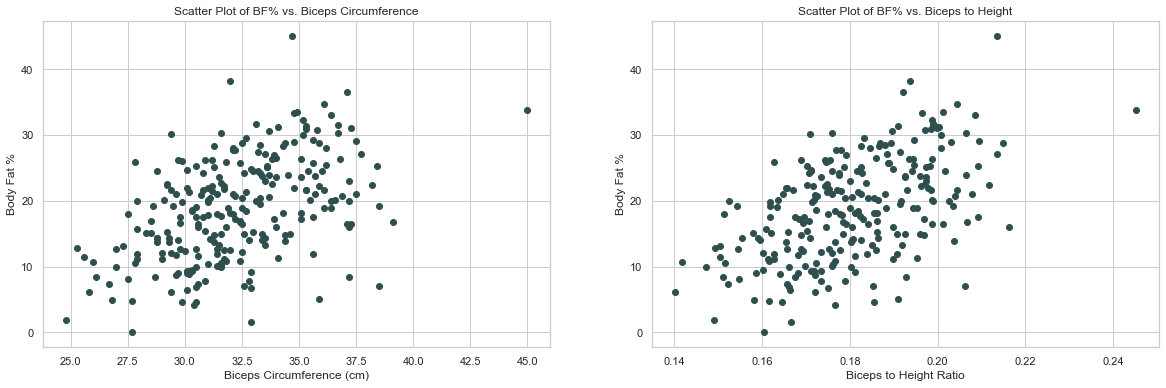

In [134]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 2, 1)
axes.scatter( body_fat2.Biceps, 
             body_fat2.BodyFat, marker="o", color="darkslategray")

axes.set_ylabel("Body Fat %")
axes.set_xlabel("Biceps Circumference (cm)")
axes.set_title("Scatter Plot of BF% vs. Biceps Circumference")


axes = figure.add_subplot(1, 2, 2)
axes.scatter( body_fat2.BTH, 
             body_fat2.BodyFat, marker="o", color="darkslategray")

axes.set_ylabel("Body Fat %")
axes.set_xlabel("Biceps to Height Ratio")
axes.set_title("Scatter Plot of BF% vs. Biceps to Height")

plt.show()
plt.close()

We can see the relationship is positive and linear. The scaled scatterplot is definitely more contracted than the unscaled version. This behaves similarly to the other correlations we have examined so far. 

<a id="v_forearm"></a>

## Body Fat v. Forearm

The forearms are muscular like bicpes, but obviously aren't as large around. Our best guesses have so far been proven wrong so we have no expecations other than a positive one with the body fat percentage.

In [135]:
body_fat2["FTH"] = body_fat["Forearm"]/body_fat["Height"]
body_fat2.FTH.describe()

count    251.000000
mean       0.160587
std        0.011017
min        0.115229
25%        0.153318
50%        0.160186
75%        0.168035
max        0.199857
Name: FTH, dtype: float64

In [136]:
print("unscaled r   = ", stats.pearsonr( body_fat2.Forearm, body_fat2.BodyFat)[0])
print("unscaled rho = ", stats.spearmanr( body_fat2.Forearm, body_fat2.BodyFat)[0])
print("scaled r   = ", stats.pearsonr( body_fat2.FTH, body_fat2.BodyFat)[0])
print("scaled rho = ", stats.spearmanr( body_fat2.FTH, body_fat2.BodyFat)[0])

unscaled r   =  0.3522014755861341
unscaled rho =  0.38569832668167014
scaled r   =  0.38940822753985815
scaled rho =  0.40087896277546203


Pearsons (.35) and Spearmans (.40) show a weak relationship. Scaling the forearm does improve the relationship but only slightly and more so for Pearsons. 

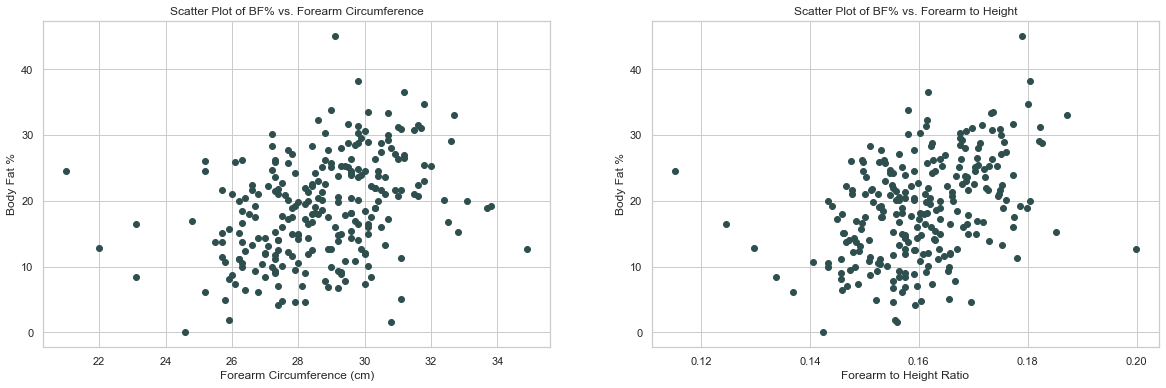

In [137]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 2, 1)
axes.scatter( body_fat2.Forearm, 
             body_fat2.BodyFat, marker="o", color="darkslategray")

axes.set_ylabel("Body Fat %")
axes.set_xlabel("Forearm Circumference (cm)")
axes.set_title("Scatter Plot of BF% vs. Forearm Circumference")


axes = figure.add_subplot(1, 2, 2)
axes.scatter( body_fat2.FTH, 
             body_fat2.BodyFat, marker="o", color="darkslategray")

axes.set_ylabel("Body Fat %")
axes.set_xlabel("Forearm to Height Ratio")
axes.set_title("Scatter Plot of BF% vs. Forearm to Height")

plt.show()
plt.close()

The relationship between forearm and body fat does not at first glance reveal a strong positive relationship. It's widly variable. Perhaps the body simply does not like to store fat in the forearms and so it is not a good predictive variable, much like the neck and forearm.

<a id="v_wrist"></a>

## Body Fat v. Wrist

The wrist is the upper limb equivalent to the ankle and so we should expect a similar relationship with body fat.

In [138]:
body_fat2["WTH"] = (body_fat["Wrist"])/body_fat["Height"]
body_fat2.WTH.describe()

count    251.000000
mean       0.102158
std        0.005112
min        0.089911
25%        0.098392
50%        0.102091
75%        0.105177
max        0.122548
Name: WTH, dtype: float64

In [139]:
print("unscaled r   = ", stats.pearsonr( body_fat2.Wrist, body_fat2.BodyFat)[0])
print("unscaled rho = ", stats.spearmanr( body_fat2.Wrist, body_fat2.BodyFat)[0])
print("scaled r   = ", stats.pearsonr( body_fat2.WTH, body_fat2.BodyFat)[0])
print("scaled rho = ", stats.spearmanr( body_fat2.WTH, body_fat2.BodyFat)[0])

unscaled r   =  0.3331529282292654
unscaled rho =  0.31103740235361255
scaled r   =  0.3751930602282546
scaled rho =  0.33874526291620743


The Pearsons (.33) and Spearman (.31) are pretty similar to ankles. The scaling with height does improve the correlation but more so for Pearsons (.38) and only slightly for Spearmans (.34).

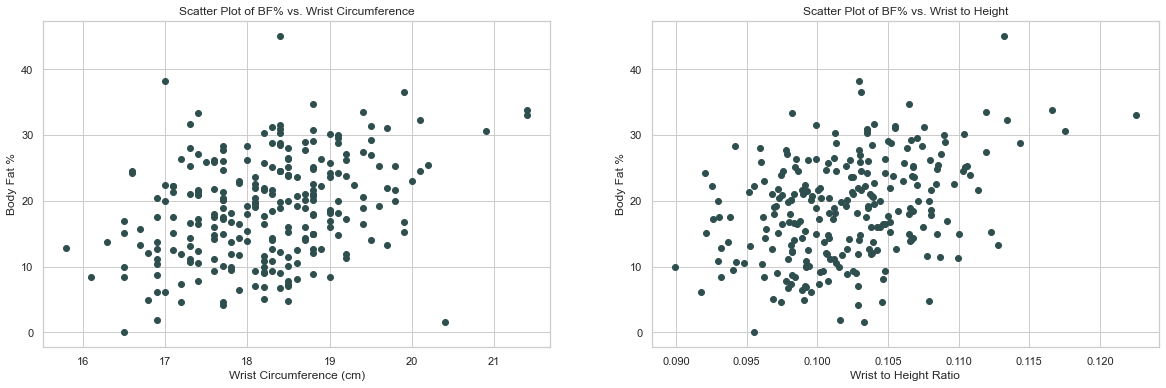

In [140]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 2, 1)
axes.scatter( body_fat2.Wrist, 
             body_fat2.BodyFat, marker="o", color="darkslategray")

axes.set_ylabel("Body Fat %")
axes.set_xlabel("Wrist Circumference (cm)")
axes.set_title("Scatter Plot of BF% vs. Wrist Circumference")


axes = figure.add_subplot(1, 2, 2)
axes.scatter( body_fat2.WTH, 
             body_fat2.BodyFat, marker="o", color="darkslategray")

axes.set_ylabel("Body Fat %")
axes.set_xlabel("Wrist to Height Ratio")
axes.set_title("Scatter Plot of BF% vs. Wrist to Height")

plt.show()
plt.close()

We see a muddy but positive, linear relationship between wrist cicumference and body fat percentage. 

Now that we've finished analyzing all the pair wise relationships, let's sort all the features by Pearson's correlation. After all our analysis we should 27 columns with 251 observations.

In [141]:
body_fat2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 251 entries, 0 to 251
Data columns (total 29 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   BodyFat    251 non-null    float64
 1   BF_Group   251 non-null    object 
 2   Density    251 non-null    float64
 3   Age        251 non-null    int64  
 4   Age_Group  251 non-null    int64  
 5   Weight     251 non-null    float64
 6   Height     251 non-null    float64
 7   Neck       251 non-null    float64
 8   Chest      251 non-null    float64
 9   Abdomen    251 non-null    float64
 10  Hip        251 non-null    float64
 11  Thigh      251 non-null    float64
 12  Knee       251 non-null    float64
 13  Ankle      251 non-null    float64
 14  Biceps     251 non-null    float64
 15  Forearm    251 non-null    float64
 16  Wrist      251 non-null    float64
 17  BMI        251 non-null    float64
 18  ATH        251 non-null    float64
 19  NTH        251 non-null    float64
 20  CTH       

Next we can sort the features by the correlation coefficient.

In [142]:
r = {}

for column in body_fat2.columns:
    if column == "BodyFat" or column == "Density" or column == "BF_Group":
        continue
    else:
        r[column] = stats.spearmanr( body_fat2[column], body_fat2.BodyFat)[0]
        
for w in sorted(r, key=r.get, reverse=True):
    print(f"{w:9}:{r[w]*100:.2f}")

ATH      :82.81
Abdomen  :80.61
ABTH     :77.59
BMI      :71.57
CTH      :68.37
HTH      :66.84
Chest    :66.13
Weight   :59.90
Hip      :59.68
TTH      :58.50
KTH      :57.59
Thigh    :53.24
BTH      :51.63
NTH      :49.31
Biceps   :48.76
Neck     :48.74
Knee     :47.46
FTH      :40.09
Forearm  :38.57
WTH      :33.87
AKTH     :31.54
Wrist    :31.10
Ankle    :29.47
Age_Group:28.47
Age      :26.47
Height   :-0.24


After sorting the columns by their spearman's coefficient we can see the strongest correlators (rho > 70%) are Abdomen to Height (83%), Abdomen (81%), Abdomen to Hip (77%), BMI (72%).

In perfomring our EDA we have eliminated bad data, cleaned up impossible data, and added many more columns. We would like to use this later in our modeling and so therefore we will upload it to our datawarehouse in a second table, Body_Fat2. 

In [143]:
cur = con.cursor()
cur.execute("""CREATE TABLE IF NOT EXISTS Body_Fat2 (id INTEGER PRIMARY KEY,
            BodyFat NUMERIC, BF_Group TEXT, Density NUMERIC, Age NUMERIC, Age_Group NUMERIC, Weight NUMERIC, 
            Height NUMERIC, Neck NUMERIC, Chest NUMERIC, Abdomen NUMERIC, Hip NUMERIC, Thigh NUMERIC,
            Knee NUMERIC, Ankle NUMERIC, Biceps NUMERIC, Forearm NUMERIC,  Wrist NUMERIC, BMI NUMERIC, 
            ATH NUMERIC, NTH NUMERIC, CTH NUMERIC, HTH NUMERIC, ABTH NUMERIC, TTH NUMERIC, KTH NUMERIC, 
            AKTH NUMERIC, BTH NUMERIC, FTH NUMERIC, WTH NUMERIC, 
            FOREIGN KEY(ID) REFERENCES Body_Fat(id))""")
con.commit()

In [144]:
body_fat2.to_sql('Body_Fat2', con, if_exists='replace', index = False)

251

Let's double check our new database to make sure we have 251 observations and 30 columns.

In [145]:
print("Number of observations:", list(con.execute("SELECT COUNT(*) FROM Body_Fat2"))[0][0])

Number of observations: 251


We are ready to now model our data. 

### References: ###

Siri, W.E. (1956), "Gross composition of the body", in Advances in Biological and Medical Physics, vol. IV, edited by J.H. Lawrence and C.A. Tobias, Academic Press, Inc., New York.

Guerra, Amaral et al (2010). “Accuracy of Siri and Brozek Equations in the Percent Body Fat Estimation in Older Adults,” in The Journal of Nutrition, Healtgh and Aging, vol. IV.  

Katch, Frank and McArdle, William (1977). Nutrition, Weight Control, and Exercise, Houghton Mifflin Co., Boston.

Brozek J, Grande F, Anderson T, Keys A. Densitometric analysis of body composition: Revision of some quantitative assumptions. Ann N Y Acad Sci 1963; 26(110):113-40.

Hoor et al. (2018). "A Benefit of Being Heavier Is Being Strong: a Cross-Sectional Study in Young Adults", in Sports Medicine - Open, vol. IV, Article 12. 